# Shopper subcase

**Goal: detect that 2 items are complementary by looking at the probability of the basket with both of them (this probability should be high even though they have never been sold together in the training data)**

Without taking into account the assortment of the shops, SHOPPER will take one of the 2 complementary items as a negative sample of the other one during training and consequently reduce the probability of having both of them in the same basket ; while the version of SHOPPER which takes into account the assortment of the shops won't take one of the 2 complementary items as a negative sample of the other one.

In [1]:
import os
import sys

sys.path.append("../../")
print(os.getcwd())

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from choice_learn.basket_models import Trip, TripDataset
from choice_learn.basket_models.alea_carta import AleaCarta


/Users/julesdesir/Documents/Etudes/Mines-Paris/Stages/Cesure/Stage-recherche-Artefact-Research-Center/Sauvegarde-documents-Artefact/GitHub-repositories/choice-learn/notebooks/basket_models


## Generate a dataset with an interaction matrix

**Items:**
- Complementary pairs of items (the probability of these pairs should increase during training): 
    - $1$ / $2$ / $3$ & $4$ / $5$ / $6$
- Substitutable items:
    - $1$ & $2$ & $3$
    - $4$ & $5$ & $6$
- (Optionally) other items without special relations:
    - $7$, $8$, ...
    
--> Concrete example:
- Item 1 = pasta 1
- Item 2 = pasta 2
- Item 3 = pasta 3
- Item 4 = sauce 1
- Item 5 = sauce 2
- Item 6 = sauce 3
- Item 7, 8, ... = water 1, 2, ...

**3 assortments:**
- Training set:
    - Store 1: $\mathcal{A}_1$ = all items except $3$ & $6$
    - Store 2: $\mathcal{A}_2$ = all items except $2$ & $4$
    - Store 3: $\mathcal{A}_3$ = all items except $1$ & $5$
- Test set:
    - Store 4: $\mathcal{A}_4$ = all items except $1$ & $2$

--> ~~Items $2$ / $6$ and items $3$ / $4$ are never available both at the same time in the training set~~

**Baskets in the training set (must be compatible with the assortment of the corresponding trips):**
- Generated by sampling from the interaction matrix following a given distribution

    

In [2]:
# n_items = 6
n_items = 8

In [3]:
def create_interaction_matrix(n: int, single_option: bool = False) -> np.ndarray:
    """Generate a random interaction matrix of size n x n.
    
    The matrix is symmetric and the diagonal is filled with zeros.
    The matrix is divided into two parts:
    - Complementary pairs (positive values)
    - Substitutable pairs (negative values)

    Parameters
    ----------
    n: int
        Size of the square matrix
    single_option: bool, optional
        If True, add a column representing single item options
        By default False
    
    Returns
    -------
    matrix: np.ndarray
        The interaction matrix
    """
    matrix = np.zeros((n, n))
    # mid = n // 2
    
    for i in range(n):
        for j in range(i + 1):
            # if (i > mid and j <= mid and j > 0 ) or (i <= mid and j > mid and i >0):
            if (i in [3, 4, 5] and j in [0, 1, 2]) or (i in [0, 1, 2] and j in [3, 4, 5]):
                # Complementary pair: >= 0
                # Draw a sample from the Gaussian distribution
                matrix[i, j] = np.random.normal(2, 1)
            elif (i in [3, 4, 5] and j in [3, 4, 5]) or (i in [0, 1, 2] and j in [0, 1, 2]):
                # Substitutable pair: <= 0
                # Draw a sample from the Gaussian distribution
                matrix[i, j] =  - 1 * np.random.normal(2, 1)
            else:
                # No interaction: 0 with small Gaussian noise
                matrix[i, j] = np.random.normal(loc=0, scale=0.05)
            
            # Copy the lower triangle to the upper triangle
            matrix[j, i] = matrix[i, j]

        # Same item
        matrix[i, i] = 0
    
    if single_option:
        # Add a column to the right for single item options
        matrix = np.hstack((matrix, np.random.normal(1, 0.5, (n, 1))))
    
    return matrix

In [4]:
interaction_matrix = create_interaction_matrix(n_items)

print(interaction_matrix.shape)
print(interaction_matrix)

(8, 8)
[[ 0.00000000e+00 -3.67518652e+00 -3.01619212e+00  1.77924425e+00
   1.19900546e+00  3.79397972e+00 -3.51589626e-03 -3.97524598e-02]
 [-3.67518652e+00  0.00000000e+00 -7.55582223e-01  2.35728820e+00
   1.92408422e+00  7.55710595e-01  1.03918636e-01 -6.02726101e-02]
 [-3.01619212e+00 -7.55582223e-01  0.00000000e+00  9.15319287e-01
   1.54510264e+00  1.70716788e+00 -3.40987863e-02 -7.48182192e-02]
 [ 1.77924425e+00  2.35728820e+00  9.15319287e-01  0.00000000e+00
  -3.00223431e+00 -4.52881368e-01 -1.50168736e-02  7.88553066e-03]
 [ 1.19900546e+00  1.92408422e+00  1.54510264e+00 -3.00223431e+00
   0.00000000e+00 -1.90882514e+00  6.15132286e-02  7.11612918e-02]
 [ 3.79397972e+00  7.55710595e-01  1.70716788e+00 -4.52881368e-01
  -1.90882514e+00  0.00000000e+00  9.30744784e-03 -2.56065906e-02]
 [-3.51589626e-03  1.03918636e-01 -3.40987863e-02 -1.50168736e-02
   6.15132286e-02  9.30744784e-03  0.00000000e+00 -5.80831211e-02]
 [-3.97524598e-02 -6.02726101e-02 -7.48182192e-02  7.88553066e

In [5]:
interaction_matrix_single_option = create_interaction_matrix(n_items, single_option=True)

print(interaction_matrix_single_option.shape)
print(interaction_matrix_single_option)

(8, 9)
[[ 0.00000000e+00 -1.18650076e+00 -1.03067586e+00  1.84879131e+00
  -1.16477660e+00  8.19752570e-01 -2.90990940e-02 -4.39533215e-03
   8.78602664e-01]
 [-1.18650076e+00  0.00000000e+00 -1.56827664e+00  1.66309432e+00
   1.78261501e+00  3.13345005e+00 -7.22808563e-03 -3.15627085e-02
   1.44940601e+00]
 [-1.03067586e+00 -1.56827664e+00  0.00000000e+00  2.13061552e+00
   2.62706146e+00  4.98588674e-01 -4.09813985e-02 -1.29914557e-02
   1.02030581e+00]
 [ 1.84879131e+00  1.66309432e+00  2.13061552e+00  0.00000000e+00
  -2.80725435e+00 -2.48812329e+00 -8.86406380e-02 -8.31949979e-02
   1.74738793e+00]
 [-1.16477660e+00  1.78261501e+00  2.62706146e+00 -2.80725435e+00
   0.00000000e+00 -2.30558815e+00 -2.58617986e-03  2.91186040e-02
   5.49698104e-01]
 [ 8.19752570e-01  3.13345005e+00  4.98588674e-01 -2.48812329e+00
  -2.30558815e+00  0.00000000e+00 -2.44485867e-02  9.74439863e-03
   1.66028546e+00]
 [-2.90990940e-02 -7.22808563e-03 -4.09813985e-02 -8.86406380e-02
  -2.58617986e-03 -2.

In [6]:
# Test: consider that the neutral items 7 and 8 are almost always single when selected
interaction_matrix_single_option = np.array(
    [
        [0., -1., -1., 2., 2., 2., 0., 0., 0.],
        [-1., 0., -1., 2., 2., 2., 0., 0., 0.],
        [-1., -1., 0., 2., 2., 2., 0., 0., 0.],
        [2., 2., 2., 0., -1., -1., 0., 0., 0.],
        [2., 2., 2., -1., 0., -1., 0., 0., 0.],
        [2., 2., 2., -1., -1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 10.],
        [0., 0., 0., 0., 0., 0., 0., 0., 10.],
    ]
)

print(f"{interaction_matrix_single_option.shape=}")

interaction_matrix_single_option.shape=(8, 9)


In [7]:
def plot_interaction_matrix(matrix: np.ndarray, half: bool = False) -> None:
    """Plot the interaction matrix.
    
    The matrix is displayed with a color map and the value
    of each cell is displayed inside the cell.

    Parameters
    ----------
    matrix: np.ndarray
        The interaction matrix to plot
    half: bool, optional
        If True, only the lower half of the matrix is displayed
        By default False

    Returns
    -------
    matrix: np.ndarray
        The interaction matrix
    """
    if half:
        # Mask: elements above the k-th diagonal are set to False, rest to True
        mask = ~np.triu(np.ones_like(matrix, dtype=bool), k=0)
        matrix = np.ma.array(matrix, mask=mask)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='coolwarm', interpolation='none', vmin=-1, vmax=1)
    plt.colorbar(label='Interaction Value')
    plt.title('Interaction Matrix')
    plt.xlabel('Item B')
    plt.ylabel('Item A')

    if matrix.shape[1] == matrix.shape[0]:
        # No single item option
        plt.xticks(ticks=np.arange(matrix.shape[0]), labels=np.arange(1, matrix.shape[0] + 1))
        plt.yticks(ticks=np.arange(matrix.shape[1]), labels=np.arange(1, matrix.shape[1] + 1))
    
    else:
        # Add a column to the right for single item options
        plt.xticks(ticks=np.arange(matrix.shape[0] + 1), labels=np.append(np.arange(1, matrix.shape[1]), "single"))
        plt.yticks(ticks=np.arange(matrix.shape[1]), labels=np.arange(1, matrix.shape[1] + 1))

    # Display the value inside each case
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if not half or (half and j >= i):
                plt.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='black')
    
    plt.show()

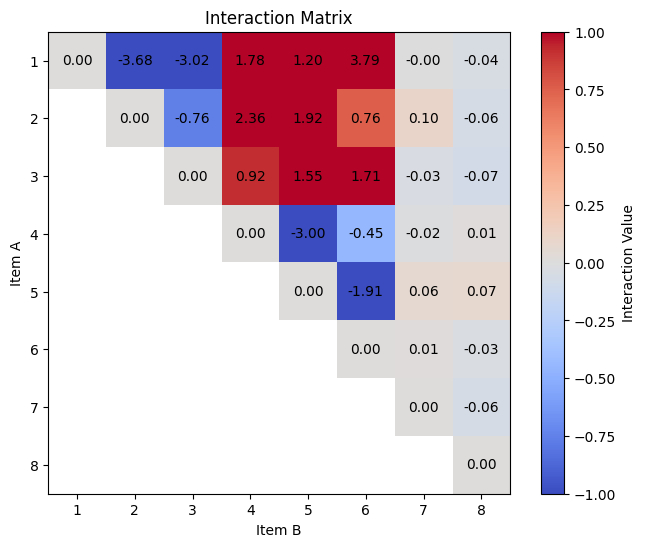

In [8]:
plot_interaction_matrix(interaction_matrix, half=True)

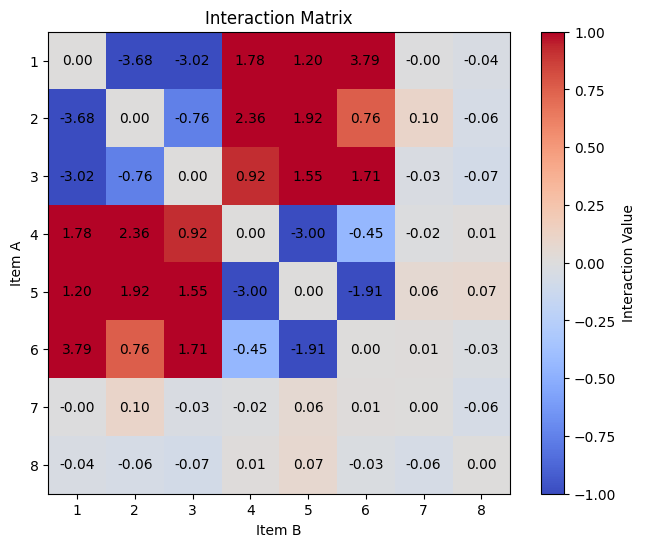

In [9]:
plot_interaction_matrix(interaction_matrix, half=False)

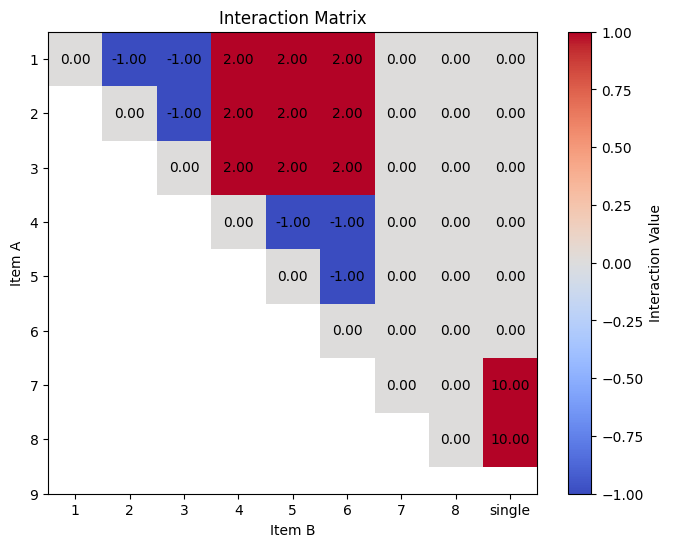

In [10]:
plot_interaction_matrix(interaction_matrix_single_option, half=True)

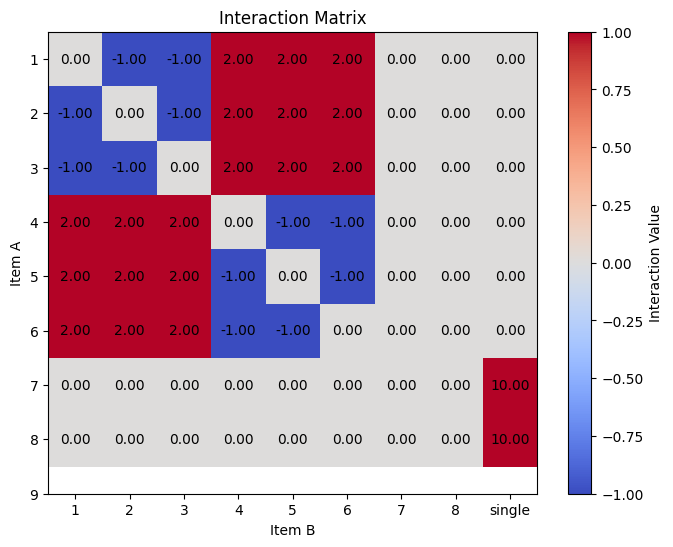

In [11]:
plot_interaction_matrix(interaction_matrix_single_option, half=False)

In [12]:
def generate_pairs(
    interaction_matrix: np.ndarray,
    assortment: np.ndarray,
    num_baskets: int
) -> list:
    """Generate pairs of items based on the interaction matrix.

    Size of the baskets: 2

    Parameters
    ----------
    interaction_matrix: np.ndarray
        The interaction matrix to plot
    assortment: np.ndarray
        The assortment of items available in the store
    num_baskets: int
        The number of baskets to generate

    Returns
    -------
    baskets: list
        List of generated baskets
    """
    n_items = interaction_matrix.shape[0]

    # The interaction matrix should have a shape of (n_items, n_items) to generate pairs of items
    if interaction_matrix.shape[1] == n_items + 1:
        # Single item option
        print("Interaction matrix of shape (n_items, n_items + 1), generating baskets of varying size 1 or 2.")
        return generate_baskets(interaction_matrix, assortment, num_baskets)
    elif interaction_matrix.shape[1] != n_items:
        raise ValueError(
            "The interaction matrix must have a shape of (n_items, n_items + 1) "
            "or (n_items, n_items)."
        )

    # Build the list of available items from the assortment
    available_items = np.array([item_id for item_id in range(interaction_matrix.shape[0]) if assortment[item_id] == 1])
    
    baskets = []
    for _ in range(num_baskets):
        # Distribution for the first item with weights sampled from an uniform distribution
        normal_dist = np.random.uniform(0, 1, size=len(available_items))
        normal_dist /= np.sum(normal_dist)
        item_a = np.random.choice(
            available_items,
            p=normal_dist
        )

        # Get probabilities of the next item given the previous item
        # by applying the softmax function to the interaction values
        # of the row corresponding to the previous item
        probabilities = np.exp(interaction_matrix[item_a, :])
        probabilities /= probabilities.sum()
        item_b = None
        while (item_b is None) or (item_b == item_a) or (item_b not in available_items):
            # No duplicate items
            item_b = np.random.choice(n_items, p=probabilities)
        
        baskets.append(np.array([item_a, item_b]))

    return baskets


def generate_baskets(
    interaction_matrix: np.ndarray,
    assortment: np.ndarray,
    num_baskets: int
) -> list:
    """Generate baskets based on the interaction matrix.

    Size of the baskets: 1 or 2

    Parameters
    ----------
    interaction_matrix: np.ndarray
        The interaction matrix to plot
    assortment: np.ndarray
        The assortment of items available in the store
    num_baskets: int
        The number of baskets to generate

    Returns
    -------
    baskets: list
        List of generated baskets
    """
    n_items = interaction_matrix.shape[0]

    # The interaction matrix should have a shape of (n_items, n_items + 1)
    # to include the single item option
    if interaction_matrix.shape[1] == n_items:
        # No single item option
        print("Square interaction matrix, generating pairs instead of baskets of varying size 1 or 2.")
        return generate_pairs(interaction_matrix, assortment, num_baskets)
    elif interaction_matrix.shape[1] != n_items + 1:
        raise ValueError(
            "The interaction matrix must have a shape of (n_items, n_items + 1) "
            "or (n_items, n_items)."
        )

    # Build the list of available items from the assortment
    available_items = np.array([item_id for item_id in range(interaction_matrix.shape[0]) if assortment[item_id] == 1])
    available_items_with_single_option = np.append(available_items, n_items)

    # Distribution for the first item with weights sampled from an uniform distribution
    normal_dist = np.random.uniform(0, 1, size=len(available_items))
    normal_dist /= np.sum(normal_dist)
    
    baskets = []
    for _ in range(num_baskets):
        item_a = np.random.choice(
            available_items,
            p=normal_dist
        )

        # Get probabilities of the next item given the previous item
        # by applying the softmax function to the interaction values
        # of the row corresponding to the previous item
        # Shape: (n_items + 1,) (because of the single option added at the end)
        probabilities = np.exp(interaction_matrix[item_a, :])
        probabilities /= probabilities.sum()
        item_b = None
        while (item_b is None) or (item_b == item_a) or (item_b not in available_items_with_single_option):
            # No duplicate items
            item_b = np.random.choice(n_items + 1, p=probabilities)

        if item_b == n_items:
            # Single option
            baskets.append(np.array([item_a]))
        else:
            baskets.append(np.array([item_a, item_b]))

    return baskets


In [13]:
a0, a1, a2, a3, a4 = np.ones(n_items), np.ones(n_items), np.ones(n_items), np.ones(n_items), np.ones(n_items)
a1[0], a1[3] = 0, 0
a2[1], a2[4] = 0, 0
# a1[2] = 0
# a2[3] = 0
a3[2], a3[5] = 0, 0
a4[3], a4[2] = 0, 0

available_items = np.array([a0, a1, a2, a3, a4])

print(f"{available_items=}")

available_items=array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1., 0., 1., 1.],
       [1., 1., 0., 0., 1., 1., 1., 1.]])


In [14]:
num_baskets = 10
# num_baskets = 10_000

purchases_assortment_0 = generate_baskets(
    interaction_matrix=interaction_matrix_single_option,
# purchases_assortment_0 = generate_pairs(
#     interaction_matrix=interaction_matrix,
    assortment=available_items[0],
    # All baskets with assortment 0 (ie all items / no assortment taken into account)
    num_baskets=num_baskets,
)
purchases_assortment_1 = generate_baskets(
    interaction_matrix=interaction_matrix_single_option,
# purchases_assortment_1 = generate_pairs(
#     interaction_matrix=interaction_matrix,
    assortment=available_items[1],
    # Half of the baskets with assortment 1
    num_baskets=num_baskets // 3,
)
purchases_assortment_2 = generate_baskets(
    interaction_matrix=interaction_matrix_single_option,
# purchases_assortment_2 = generate_pairs(
#     interaction_matrix=interaction_matrix,
    assortment=available_items[2],
    # Half of the baskets with assortment 2
    num_baskets=num_baskets // 3,
)
purchases_assortment_3 = generate_baskets(
    interaction_matrix=interaction_matrix_single_option,
# purchases_assortment_3 = generate_pairs(
#     interaction_matrix=interaction_matrix,
    assortment=available_items[3],
    # All the baskets with assortment 3
    num_baskets=num_baskets // 3,
)
purchases_assortment_4 = generate_baskets(
    interaction_matrix=interaction_matrix_single_option,
# purchases_assortment_3 = generate_pairs(
#     interaction_matrix=interaction_matrix,
    assortment=available_items[4],
    # All the baskets with assortment 3
    num_baskets=num_baskets,
)

In [15]:
print(f"{purchases_assortment_0[:10]=}")

purchases_assortment_0[:10]=[array([6]), array([0, 6]), array([5, 1]), array([5, 6]), array([7]), array([0, 3]), array([7]), array([0, 3]), array([5, 1]), array([0, 3])]


In [16]:
purchases_assortment_0

[array([6]),
 array([0, 6]),
 array([5, 1]),
 array([5, 6]),
 array([7]),
 array([0, 3]),
 array([7]),
 array([0, 3]),
 array([5, 1]),
 array([0, 3])]

In [17]:
base_assortment_0 = [
    [0, 3],
    [0, 4],
    [0, 5],
    [1, 3],
    [1, 4],
    [1, 5],
    [2, 3],
    [2, 4],
    [2, 5],
]
neutral = [
    [0, 3, 6],
    [0, 4, 6],
    [0, 5, 6],
    [1, 3, 6],
    [1, 4, 6],
    [1, 5, 6],
    [2, 3, 6],
    [2, 4, 6],
    [2, 5, 6],
    [0, 3, 7],
    [0, 4, 7],
    [0, 5, 7],
    [1, 3, 7],
    [1, 4, 7],
    [1, 5, 7],
    [2, 3, 7],
    [2, 4, 7],
    [2, 5, 7],
    [6, 7],
    [6, 7],
    [6],
    [7],
    [7],
    [6]
]

random_0 = [
    [0, 1, 3],
    [2, 4, 5],
    [1, 3, 4],
    [1],
    [2],
    [5],
    [0],
    [4],
]
purchases_assortment_0 = []
for _ in range(10):
    purchases_assortment_0 += base_assortment_0
for _ in range(2):
    purchases_assortment_0 += neutral
purchases_assortment_0 += random_0

In [18]:
# 0 and 3 missing

base_assortment_1 = [
    # [0, 3],
    # [0, 4],
    # [0, 5],
    # [ 1, 3],
    [1, 4],
    [1, 5],
    # [2, 3],
    [2, 4],
    [2, 5],
]
neutral_1 = [
    # [0, 3, 6],
    # [0, 4, 6],
    # [0, 5, 6],
    # [1, 3, 6],
    [1, 4, 6],
    [1, 5, 6],
    # [2, 3, 6],
    [2, 4, 6],
    [2, 5, 6],
    # [0, 3, 7],
    # [0, 4, 7],
    # [0, 5, 7],
    # [1, 3, 7],
    [1, 4, 7],
    [1, 5, 7],
    # [2, 3, 7],
    [2, 4, 7],
    [2, 5, 7],
    [6, 7],
    [6, 7],
    [6],
    [7],
]
random_1 = [
    # [0, 1, 3],
    [2, 4, 5],
    [2, 3, 4],
    # [1, 3, 4],
    [1],
    [2],
    [5],
    # [0],
    [4],
]
purchases_assortment_1 = []
for _ in range(10):
    purchases_assortment_1 += base_assortment_1
for _ in range(2):
    purchases_assortment_1 += neutral_1
purchases_assortment_1 += random_1

In [19]:
# 2 and 5 missing

base_assortment_3 = [
    [0, 3],
    [0, 4],
    # [0, 5],
    [1, 3],
    [1, 4],
    # [1, 5],
    # [2, 3],
    # [2, 4],
    # [2, 5],
]
neutral_3 = [
    [0, 3, 6],
    [0, 4, 6],
    # [0, 5, 6],
    [1, 3, 6],
    [1, 4, 6],
    # [1, 5, 6],
    # [2, 3, 6],
    # [2, 4, 6],
    # [2, 5, 6],
    [0, 3, 7],
    [0, 4, 7],
    # [0, 5, 7],
    [1, 3, 7],
    [1, 4, 7],
    # [1, 5, 7],
    # [2, 3, 7],
    # [2, 4, 7],
    # [2, 5, 7],
    [6, 7],
    [6, 7],
    [6],
    [7],
]
random_3 = [
    [0, 1, 3],
    # [2, 4, 5],
    # [2, 3, 4]
    [1, 3, 4],
    [1],
    # [2],
    # [5],
    [0],
    [4],
]

purchases_assortment_3 = []
for _ in range(10):
    purchases_assortment_3 += base_assortment_3
for _ in range(2):
    purchases_assortment_3 += neutral_3
purchases_assortment_3 += random_3

In [20]:
# 1 & 4 missing
base_purchases = [
    [0, 3],
    # [0, 4],
    [0, 5],
    # [1, 3],
    # [1, 4],
    # [1, 5],
    [2, 3],
    # [2, 4],
    [2, 5],
]
neutral_2 = [
    [0, 3, 6],
    # [0, 4, 6],
    [0, 5, 6],
    # [1, 3, 6],
    # [1, 4, 6],
    # [1, 5, 6],
    [2, 3, 6],
    # [2, 4, 6],
    [2, 5, 6],
    [0, 3, 7],
    # [0, 4, 7],
    [0, 5, 7],
    # [1, 3, 7],
    # [1, 4, 7],
    # [1, 5, 7],
    [2, 3, 7],
    # [2, 4, 7],
    [2, 5, 7],
    [6, 7],
    [6, 7],
    [6],
    [7],
]
random = [
    [0, 1, 3],
    # [2, 4, 5],
    [1, 3, 4],
    [1],
    # [2],
    # [5],
    [0],
    [4],
]
purchases_assortment_2  = []
for _ in range(10):
    purchases_assortment_2 += base_purchases
for _ in range(2):
    purchases_assortment_2 += neutral_2
purchases_assortment_2 += random

In [21]:
# 2 & 3 missing
test_base_purchases = [
    #[0, 3],
    [0, 4],
    [0, 5],
    # [1, 3],
    [1, 4],
    [1, 5],
    # [2, 3],
    # [2, 4],
    # [2, 5],
]
test_neutral = [
    # [0, 3, 6],
    [0, 4, 6],
    [0, 5, 6],
    # [1, 3, 6],
    [1, 4, 6],
    [1, 5, 6],
    # [2, 3, 6],
    # [2, 4, 6],
    # [2, 5, 6],
    # [0, 3, 7],
    [0, 4, 7],
    [0, 5, 7],
    # [1, 3, 7],
    [1, 4, 7],
    [1, 5, 7],
    # [2, 3, 7],
    # [2, 4, 7],
    # [2, 5, 7],
    [6, 7],
    [6, 7],
    [6],
    [7],
]
test_random = [
    # [0, 1, 3],
    # [2, 4, 5],
    # [1, 3, 4],
    [1],
    [2],
    [5],
    [0],
    [4],
]
test_purchase_assortment  = []
for _ in range(10):
    test_purchase_assortment += test_base_purchases
for _ in range(2):
    test_purchase_assortment += test_neutral
test_purchase_assortment += test_random

In [22]:
print(f"{len(purchases_assortment_0)=}, {len(purchases_assortment_1)=}, {len(purchases_assortment_2)=}, {len(purchases_assortment_3)=}, {len(purchases_assortment_4)=}\n")

print(f"With all items available: {purchases_assortment_0[:10]=}")
print(f"From assortment without 3 & 6: {purchases_assortment_1[:10]=}")
print(f"From assortment without 2 & 4: {purchases_assortment_2[:10]=}")
print(f"From assortment without 1 & 5: {purchases_assortment_3[:10]=}\n")
print(f"From assortment without 1 & 2: {purchases_assortment_4[:10]=}\n")

min_length_purchases_assortment_0, max_length_purchases_assortment_0 = min(len(basket) for basket in purchases_assortment_0), max(len(basket) for basket in purchases_assortment_0)
print(f"Minimum and maximum lengths of arrays in purchases_assortment_0: {min_length_purchases_assortment_0} & {max_length_purchases_assortment_0}")
min_length_purchases_assortment_1, max_length_purchases_assortment_1= min(len(basket) for basket in purchases_assortment_1), max(len(basket) for basket in purchases_assortment_1)
print(f"Minimum and maximum lengths of arrays in purchases_assortment_1: {min_length_purchases_assortment_1} & {max_length_purchases_assortment_1}")
min_length_purchases_assortment_2, max_length_purchases_assortment_2 = min(len(basket) for basket in purchases_assortment_2), max(len(basket) for basket in purchases_assortment_2)
print(f"Minimum and maximum lengths of arrays in purchases_assortment_2: {min_length_purchases_assortment_2} & {max_length_purchases_assortment_2}")

len(purchases_assortment_0)=146, len(purchases_assortment_1)=70, len(purchases_assortment_2)=69, len(purchases_assortment_3)=69, len(purchases_assortment_4)=10

With all items available: purchases_assortment_0[:10]=[[0, 3], [0, 4], [0, 5], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [0, 3]]
From assortment without 3 & 6: purchases_assortment_1[:10]=[[1, 4], [1, 5], [2, 4], [2, 5], [1, 4], [1, 5], [2, 4], [2, 5], [1, 4], [1, 5]]
From assortment without 2 & 4: purchases_assortment_2[:10]=[[0, 3], [0, 5], [2, 3], [2, 5], [0, 3], [0, 5], [2, 3], [2, 5], [0, 3], [0, 5]]
From assortment without 1 & 5: purchases_assortment_3[:10]=[[0, 3], [0, 4], [1, 3], [1, 4], [0, 3], [0, 4], [1, 3], [1, 4], [0, 3], [0, 4]]

From assortment without 1 & 2: purchases_assortment_4[:10]=[array([7]), array([1, 4]), array([0, 5]), array([4, 1]), array([4, 0]), array([0, 5]), array([6]), array([4, 0]), array([5, 0]), array([0, 5])]

Minimum and maximum lengths of arrays in purchases_assortment_0: 1 & 3
Minimum

## Comparison between basket probabilities computed by trained models (with and without taking into account the assortments) and item frequencies

In [23]:
nrows = 1

store = 0
week = 0
prices = np.arange(1, n_items + 1) * 1.1

# Trips with baskets from purchases_assortment_0 and without assortment
trip_list_train_no_assortment = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=0)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_0)
    ]
))

trip_list_train_no_assortment_bis_1 = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=0)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_1)
    ]
))
trip_list_train_no_assortment_bis_2 = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=0)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_2)
    ]
))
trip_list_train_no_assortment_bis_3 = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=0)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_3)
    ]
))
# Trips with baskets from purchases_assortment_1 and purchases_assortment_2 BUT without assortment
trip_list_train_no_assortment_bis = trip_list_train_no_assortment_bis_1 + trip_list_train_no_assortment_bis_2 + trip_list_train_no_assortment_bis_3

trip_list_train_assortment_1 = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=1)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_1)
    ]
))
trip_list_train_assortment_2 = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=2)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_2)
    ]
))
trip_list_train_assortment_3 = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=3)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_3)
    ]
))
# Trips with baskets from purchases_assortment_1 and purchases_assortment_2 and with assortments 1 and 2
trip_list_train = trip_list_train_assortment_1 + trip_list_train_assortment_2 + trip_list_train_assortment_3

# Trips with baskets from purchases_assortment_3 and with assortment 3
trip_list_test = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=4)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_4)
    ]
))

trip_dataset_train_no_assortment = TripDataset(trips=trip_list_train_no_assortment, available_items=available_items)
trip_dataset_train_no_assortment_bis = TripDataset(trips=trip_list_train_no_assortment_bis, available_items=available_items)
trip_dataset_train = TripDataset(trips=trip_list_train, available_items=available_items)
trip_dataset_test = TripDataset(trips=trip_list_test, available_items=available_items)

print(f"{len(trip_dataset_train_no_assortment)=}, {len(trip_dataset_train_no_assortment)=}, {len(trip_dataset_train)=} {len(trip_dataset_test)=}\n")

n_items_train_no_assortment, n_stores_train_no_assortment = trip_dataset_train_no_assortment.n_items, trip_dataset_train_no_assortment.n_stores
n_items_train_no_assortment_bis, n_stores_train_no_assortment_bis = trip_dataset_train_no_assortment_bis.n_items, trip_dataset_train_no_assortment_bis.n_stores
n_items_train, n_stores_train = trip_dataset_train.n_items, trip_dataset_train.n_stores
n_items_test, n_stores_test = trip_dataset_test.n_items, trip_dataset_test.n_stores

len(trip_dataset_train_no_assortment)=146, len(trip_dataset_train_no_assortment)=146, len(trip_dataset_train)=208 len(trip_dataset_test)=10



In [24]:
nrows = 1

store = 0
week = 0
prices = np.arange(1, n_items + 1) * 1.1

# Trips with baskets from purchases_assortment_0 and without assortment
trip_list_train_full_assortment = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=0)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_0)
    ]
))

trip_list_train_no_assortment_bis_1 = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=0)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_1)
    ]
))
trip_list_train_no_assortment_bis_2 = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=0)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_2)
    ]
))
trip_list_train_no_assortment_bis_3 = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=0)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_3)
    ]
))

# Trips with baskets from purchases_assortment_1 and purchases_assortment_2 BUT without assortment
trip_list_train_bad_ns = trip_list_train_no_assortment_bis_1 + trip_list_train_no_assortment_bis_2  + trip_list_train_no_assortment_bis_3

trip_list_train_assortment_1 = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=1)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_1)
    ]
))
trip_list_train_assortment_2 = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=2)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_2)
    ]
))

trip_list_train_assortment_3 = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=3)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(purchases_assortment_3)
    ]
))


trip_list_test = list(np.concatenate(
    [
        [Trip(purchases=basket, store=store, week=week, prices=prices, assortment=4)
        for _ in range(k*nrows, (k + 1)*nrows)] for k, basket in enumerate(test_purchase_assortment)
    ]
))

# Trips with baskets from purchases_assortment_1 and purchases_assortment_2 and with assortments 1 and 2
trip_list_train_good_ns = trip_list_train_assortment_1 + trip_list_train_assortment_2 + trip_list_train_assortment_3

trip_dataset_full_assortment = TripDataset(trips=trip_list_train_no_assortment, available_items=available_items)
trip_dataset_bad_ns = TripDataset(trips=trip_list_train_bad_ns, available_items=available_items)
trip_dataset_good_ns = TripDataset(trips=trip_list_train_good_ns, available_items=available_items)
test_dataset = TripDataset(trips=trip_list_test, available_items=available_items)

print(f"{len(trip_dataset_train_no_assortment)=}, {len(trip_dataset_train_no_assortment)=}, {len(trip_dataset_train)=} {len(trip_dataset_test)=}\n")

n_items = 8
n_stores = 1

len(trip_dataset_train_no_assortment)=146, len(trip_dataset_train_no_assortment)=146, len(trip_dataset_train)=208 len(trip_dataset_test)=10



In [25]:
latent_sizes = {"preferences": 6, "price": 3, "season": 3}
n_negative_samples = 3
optimizer = "adam"
lr = 1e-2
# epochs = 250
epochs = 1000
batch_size = 32

### Train a model with and without taking into account the assortments

In [26]:
model_good_ns = AleaCarta(
    # item_intercept=True,
    item_intercept=False,
    price_effects=False,
    seasonal_effects=False,
    latent_sizes=latent_sizes,
    n_negative_samples=n_negative_samples,
    optimizer=optimizer,
    lr=lr,
    epochs=epochs,
    batch_size=batch_size,
)

model_good_ns.instantiate(n_items=n_items, n_stores=n_stores)

In [27]:
available_items

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1., 0., 1., 1.],
       [1., 1., 0., 0., 1., 1., 1., 1.]])

In [28]:
# During training: trips with baskets from purchases_assortment_1, purchases_assortment_2 and purchases_assortment_3 and with assortments 1, 2 and 3
history_good_ns = model_good_ns.fit(trip_dataset=trip_dataset_good_ns)

Epoch 999 Train Loss 0.5543: 100%|██████████| 1000/1000 [00:37<00:00, 26.85it/s]


In [29]:
"""
ds = TripDataset([Trip(purchases=[0, 1], store=0, week=0, prices=np.ones((100)), assortment=0) for _ in range(1000)], np.ones((1, 100)))

history_bad_ns = model_bad_ns.fit(trip_dataset=ds)"""

'\nds = TripDataset([Trip(purchases=[0, 1], store=0, week=0, prices=np.ones((100)), assortment=0) for _ in range(1000)], np.ones((1, 100)))\n\nhistory_bad_ns = model_bad_ns.fit(trip_dataset=ds)'

In [30]:
1000000/8

125000.0

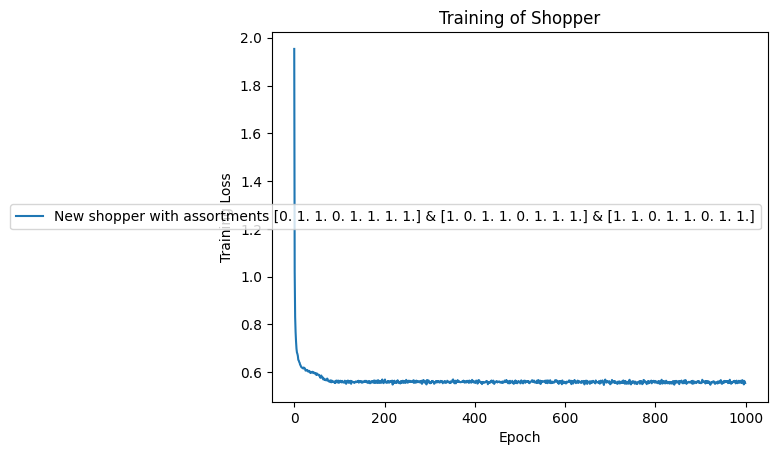

In [31]:
plt.plot(history_good_ns["train_loss"], label=f"New shopper with assortments {available_items[1]} & {available_items[2]} & {available_items[3]}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.title("Training of Shopper")
plt.show()

In [32]:
colors = plt.cm.Spectral(np.linspace(-1,2,1000))

TypeError: 'Axes' object is not subscriptable

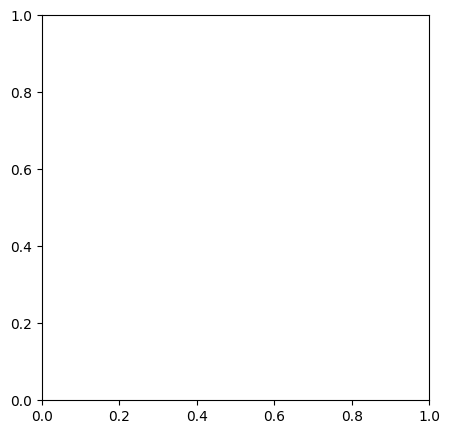

In [33]:
import matplotlib as mpl
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
for k, model in enumerate([model_good_ns]):

        mask = np.ones((8,8), dtype=bool)
        res = []
        for i in range(8):
                r = model.compute_batch_utility(item_batch=np.array(list(range(8))),
                        basket_batch=np.array([[i] for _ in range(8)]) ,
                        store_batch=np.array([0, 0, 0, 0, 0, 0, 0, 0]),
                        week_batch=np.array([0, 0, 0, 0, 0, 0, 0, 0]),
                        price_batch=np.array([[0, 0, 0, 0, 0, 0] for _ in range(8)]))
                m = np.ones(8)
                m[i] = 0
                den = np.exp(r) * m
                r = den / den.sum()
                # r = np.concatenate([tf.nn.softmax(np.concatenate([r[:i], r[i+1:]]))[:i], [.0], tf.nn.softmax(np.concatenate([r[:i], r[i+1:]]))[i:]])
                res.append(r)
                mask[i][i] = False

        res = np.stack(res)
        # np.fill_diagonal(res, np.zeros(8))
        mask = np.ma.masked_where(mask, res)

        axes[k].set_xticks([], [])
        axes[k].set_yticks([], [])
        im = axes[k].imshow(np.stack(res), cmap="Spectral", alpha=0.99, vmin=0, vmax=1)
        axes[k].imshow(mask, cmap=mpl.colors.ListedColormap(['white']), alpha=1)
        # axes[k].axis("off")
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.69])
fig.colorbar(im, cax=cbar_ax)
plt.savefig("ours_afull.pdf")
# plt.colorbar()

In [ ]:
import matplotlib as mpl
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for k, model in enumerate([model_full_assortment, model_bad_ns, model_good_ns]):

        mask = np.ones((8,8), dtype=bool)
        res = []
        for i in range(8):
                r = model.compute_batch_utility(item_batch=np.array(list(range(8))),
                        basket_batch=np.array([[i] for _ in range(8)]) ,
                        store_batch=np.array([0, 0, 0, 0, 0, 0, 0, 0]),
                        week_batch=np.array([0, 0, 0, 0, 0, 0, 0, 0]),
                        price_batch=np.array([[0, 0, 0, 0, 0, 0] for _ in range(8)]))
                m = np.ones(8)
                m[i] = 0
                m[2] = 0
                m[3] = 0
                den = np.exp(r) * m
                r = den / den.sum()
                # r = np.concatenate([tf.nn.softmax(np.concatenate([r[:i], r[i+1:]]))[:i], [.0], tf.nn.softmax(np.concatenate([r[:i], r[i+1:]]))[i:]])
                res.append(r)
                mask[i][i] = False
                mask[i][2] = False
                mask[i][3] = False
                mask[2][i] = False
                mask[3][i] = False

        res = np.stack(res)
        # np.fill_diagonal(res, np.zeros(8))
        mask = np.ma.masked_where(mask, res)

        axes[k].set_xticks([], [])
        axes[k].set_yticks([], [])
        im = axes[k].imshow(np.stack(res), cmap="Spectral", alpha=0.99, vmin=0, vmax=1)
        axes[k].imshow(mask, cmap=mpl.colors.ListedColormap(['white']), alpha=1)
        # axes[k].axis("off")
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.69])
fig.colorbar(im, cax=cbar_ax)
plt.savefig("ours_a4.pdf")
# plt.colorbar()

In [ ]:
len(test_purchase_assortment), len(purchases_assortment_0)

In [ ]:
all_ranks = {"fa": [], "bad": [], "good": []}
for z, model in zip(["fa", "bad", "good"], [model_full_assortment, model_bad_ns, model_good_ns]):
    all_probs = []
    for bask in test_purchase_assortment:
        for ite in bask:
            bbb = [k for k in bask if k != ite]
            itit = [ite]
            for j in range(8):
                if j != ite and j!= 2 and j != 3 and j not in bbb:
                    itit.append(j)
            r = model.compute_batch_utility(item_batch=np.array(itit),
                                    basket_batch=np.array([bbb for _ in range(len(itit))]) ,
                                    store_batch=np.array([0 for _ in range(len(itit))]),
                                    week_batch=np.array([0 for _ in range(len(itit))]),
                                    price_batch=np.array([0 for _ in range(len(itit))]))
            ppp = tf.nn.softmax(r)[0]
            all_probs.append(ppp)
            all_ranks[z].append(len(r)-np.argsort(np.argsort(r))[0])

    print(z, np.mean(np.log(all_probs)))
    print(np.mean(1+np.array(all_ranks[z])), np.mean(1/(1+np.array(all_ranks[z]))))

In [ ]:
# plt.plot(all_ranks["fa"])
plt.plot((np.array(all_ranks["bad"])))
plt.plot((np.array(all_ranks["good"])))

In [ ]:
for z in all_ranks.keys():
    print(z)
    print(np.mean(1/(6-np.array(all_ranks[z]))))
    print(np.mean((6-np.array(all_ranks[z]))))
    print(np.mean(1/2**(6-np.array(all_ranks[z]))))

In [ ]:
all_ranks = {"fa": [], "bad": [], "good": []}
for z, model in zip(["fa", "bad", "good"], [model_full_assortment, model_bad_ns, model_good_ns]):
    all_probs = []
    for bask in purchases_assortment_0:
        for ite in bask:
            bbb = [k for k in bask if k != ite]
            itit = [ite]
            for j in range(8):
                if j != ite and j not in bbb:
                    itit.append(j)
            r = model.compute_batch_utility(item_batch=np.array(itit),
                                    basket_batch=np.array([bbb for _ in range(len(itit))]) ,
                                    store_batch=np.array([0 for _ in range(len(itit))]),
                                    week_batch=np.array([0 for _ in range(len(itit))]),
                                    price_batch=np.array([0 for _ in range(len(itit))]))
            ppp = tf.nn.softmax(r)[0]
            all_probs.append(ppp)
            all_ranks[z].append(len(r)-np.argsort(np.argsort(r))[0])
    print(z, np.mean(np.log(all_probs)))
    print(np.mean(1+np.array(all_ranks[z])), np.mean(1/(1+np.array(all_ranks[z]))))
    # break

In [ ]:
bask

In [ ]:
np.min(all_ranks["bad"])

In [ ]:
# plt.plot(all_ranks["fa"])
plt.plot((np.array(all_ranks["bad"])))
plt.plot((np.array(all_ranks["good"])))

In [ ]:
np.mean(1/(8 - np.array(all_ranks)))

In [ ]:
r

In [ ]:
1/3.5

In [ ]:
r

In [ ]:
itit

In [ ]:
all_probs_f = all_probs

In [ ]:
plt.plot(np.log(all_probs))
plt.plot(np.log(all_probs_f))


In [ ]:
baskets_data = [_ for _ in test_purchase_assortment]
import matplotlib as mpl
import itertools
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
res = []
mask = np.ones((8,8), dtype=bool)
for i in range(8):
    r = []
    mask[i,2] = False
    mask[i,3] = False
    mask[2,i] = False
    mask[3,i] = False
    for j in range(8):
        if i == j:
            r.append(0)
            mask[i,j] = False
            continue
        elif j == 2 or j == 3:
            r.append(0)
            continue

        baskets_with_j = [basket for basket in baskets_data if j in basket]
        baskets_with_ij = [bask for basket in baskets_with_j if i in basket]
        
        """subset_items = [k for k in range(8) if (k != j and k != i)]
        for L in range(7):
            for subset in itertools.combinations(subset_items, L):
                baskets_with_ij+= [[*subset, i, j]]"""

        if len(baskets_with_ij) == 0:
            r.append(0)
        else:
            r.append( len(baskets_with_ij) / len(baskets_with_j)+np.random.normal(0, 0.02, 1)[0])
            '''vals = []
            for b in baskets_with_ij:
                vals.append(model_full_assortment.compute_batch_utility(item_batch=np.array([i]),
                    basket_batch=np.array(b) ,
                    store_batch=np.array([0]),
                    week_batch=np.array([0]),
                    price_batch=np.array([0]),
                ))'''
            # r.append(np.mean(model.compute_batch_utility(item_batch=np.array([i for _ in range(len(baskets_with_ij))]),
            #         basket_batch=baskets_with_ij ,
            #         store_batch=np.array([0 for _ in range(len(baskets_with_ij))]),
            #         week_batch=np.array([0 for _ in range(len(baskets_with_ij))]),
            #         price_batch=np.array([0 for _ in range(len(baskets_with_ij))]),
            # )))
            # r.append(np.mean(vals))
    '''print("r", r)
    r = np.concatenate([tf.nn.softmax(np.concatenate([r[:i], r[i+1:]]))[:i], [.0], tf.nn.softmax(np.concatenate([r[:i], r[i+1:]]))[i:]])
    print('p', r)'''
    res.append(r)

res = np.stack(res)
#np.fill_diagonal(res, np.zeros(8))
#im = axes.imshow(np.stack(res), cmap="Spectral")
#axes.axis("off")
#fig.colorbar(im)
mask = np.ma.masked_where(mask, np.stack(res))

fig = plt.figure()
plt.imshow(np.stack(res), cmap="Spectral", alpha = 0.99, vmin=0, vmax=1)
plt.colorbar()
plt.imshow(mask, cmap=mpl.colors.ListedColormap(['white']), alpha=1)
plt.xticks([], [])
plt.yticks([], [])

In [ ]:
+np.random.normal(0, 0.05, 1)

In [ ]:
baskets_data = [_ for _ in purchases_assortment_0]
import matplotlib as mpl
import itertools
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
res = []
mask = np.ones((8,8), dtype=bool)
for i in range(8):
    r = []
    for j in range(8):
        if i == j:
            r.append(0)
            mask[i,j] = False
            continue

        baskets_with_j = [basket for basket in baskets_data if j in basket]
        baskets_with_ij = [[k for k in basket if k!=i] for basket in baskets_with_j]
        
        """subset_items = [k for k in range(8) if (k != j and k != i)]
        for L in range(7):
            for subset in itertools.combinations(subset_items, L):
                baskets_with_ij+= [[*subset, i, j]]"""

        if len(baskets_with_ij) == 0:
            r.append(0)
        else:
            vals = []
            for b in baskets_with_ij:
                vals.append(model_full_assortment.compute_batch_utility(item_batch=np.array([i]),
                    basket_batch=np.array(b) ,
                    store_batch=np.array([0]),
                    week_batch=np.array([0]),
                    price_batch=np.array([0]),
                ))
            # r.append(np.mean(model.compute_batch_utility(item_batch=np.array([i for _ in range(len(baskets_with_ij))]),
            #         basket_batch=baskets_with_ij ,
            #         store_batch=np.array([0 for _ in range(len(baskets_with_ij))]),
            #         week_batch=np.array([0 for _ in range(len(baskets_with_ij))]),
            #         price_batch=np.array([0 for _ in range(len(baskets_with_ij))]),
            # )))
            r.append(np.mean(vals))
    print("r", r)
    r = np.concatenate([tf.nn.softmax(np.concatenate([r[:i], r[i+1:]]))[:i], [.0], tf.nn.softmax(np.concatenate([r[:i], r[i+1:]]))[i:]])
    print('p', r)
    res.append(r)

res = np.stack(res)
#np.fill_diagonal(res, np.zeros(8))
#im = axes.imshow(np.stack(res), cmap="Spectral")
#axes.axis("off")
#fig.colorbar(im)
mask = np.ma.masked_where(mask, np.stack(res))

fig = plt.figure()
plt.imshow(np.stack(res), cmap="Spectral", alpha = 0.99)
plt.colorbar()
plt.imshow(mask, cmap=mpl.colors.ListedColormap(['white']), alpha=1)
plt.xticks([], [])
plt.yticks([], [])

In [ ]:
vals

In [ ]:
i = 2
j = 3
baskets_with_j = [basket for basket in baskets_data if i in basket]
baskets_with_ij = [[k for k in basket if k!=i] for basket in baskets_with_j if j in basket]

vals = []
for b in baskets_with_ij:
    vals.append(model.compute_batch_utility(item_batch=np.array([i]),
        basket_batch=np.array(b) ,
        store_batch=np.array([0]),
        week_batch=np.array([0]),
        price_batch=np.array([0]),
    ))

In [ ]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.figure(figsize=(10, 2))
plt.imshow(gradient, aspect='auto', cmap="Spectral")
plt.axis("off")

In [ ]:
plt.imshow(np.stack(res))

In [ ]:
baskets_data = [_ for _ in purchases_assortment_0]

In [ ]:
import matplotlib as mpl
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
res = []
mask = np.ones((8,8), dtype=bool)
for i in range(8):
    r = []
    for j in range(8):
        if i == j:
            r.append(0)
            mask[i,j] = False
            continue
        baskets_with_j = [basket for basket in baskets_data if (i in basket and 2 not in basket and 3 not in basket)]
        if not baskets_with_j:
            r.append(0)
            mask[i,j] = False
            continue
        baskets_with_ij = [basket for basket in baskets_with_j if j in basket]
        r.append(len(baskets_with_ij) / len(baskets_with_j))
        #r = model.compute_batch_utility(item_batch=np.array(list(range(8))),
        #        basket_batch=np.array([[i] for _ in range(8)]) ,
        #        store_batch=np.array([0, 0, 0, 0, 0, 0, 0, 0]),
        #        week_batch=np.array([0, 0, 0, 0, 0, 0, 0, 0]),
        #        price_batch=np.array([[0, 0, 0, 0, 0, 0] for _ in range(8)]))
        #r = np.concatenate([tf.nn.softmax(np.concatenate([r[:i], r[i+1:]]))[:i], [0], tf.nn.softmax(np.concatenate([r[:i], r[i+1:]]))[i:]])
    mask[i][2] = False
    mask[i][3] = False
    mask[2][i] = False
    mask[3][i] = False
    res.append(r)

res = np.stack(res) + np.random.normal(0, 0.01, (8, 8))
#np.fill_diagonal(res, np.zeros(8))
#im = axes.imshow(np.stack(res), cmap="Spectral")
#axes.axis("off")
#fig.colorbar(im)
mask = np.ma.masked_where(mask, np.stack(res))

fig = plt.figure()
plt.imshow(res, cmap="Spectral", alpha = 0.99)
# plt.colorbar()
plt.imshow(mask, cmap=mpl.colors.ListedColormap(['white']), alpha=1)
plt.xticks([], [])
plt.yticks([], [])

In [ ]:
np.stack(res)

In [ ]:
mask

In [ ]:
for batch in trip_dataset_good_ns.iter_batch(batch_size=4):
    pass

In [ ]:
batch

In [ ]:
model_no_assortment.compute_batch_utility(item_batch=np.array(list(range(2))),
        basket_batch=np.array([[0] for _ in range(2)]) ,
        store_batch=np.array([0, 0]),
        week_batch=np.array([0, 0]),
        price_batch=np.array([[0, 0] for _ in range(2)])
        )

In [ ]:
model_no_assortment.compute_batch_utility(item_batch=np.array(list(range(6))),
        basket_batch=np.array([[0] for _ in range(6)]) ,
        store_batch=np.array([0, 0, 0, 0, 0, 0]),
        week_batch=np.array([0, 0, 0, 0, 0, 0]),
        price_batch=np.array([[0, 0, 0, 0, 0, 0] for _ in range(6)])
        )

In [ ]:
M = tf.matmul(model_no_assortment.alpha, tf.transpose(model_no_assortment.alpha))
M = tf.linalg.set_diag(M, tf.zeros(M.shape[0]))
plt.imshow(M)

### Visualize the embeddings

Display item popularity

In [ ]:
if model.item_intercept:
    print(np.exp(model_no_assortment.lambda_.numpy()))
    print(np.exp(model_no_assortment_bis.lambda_.numpy()))
    print(np.exp(model.lambda_.numpy()))

In [ ]:
if model.item_intercept:
    # Calculate the frequency of each item in the datasets
    item_counts_assortment_0 = np.zeros(n_items)
    for basket in purchases_assortment_0:
        for item in basket:
            item_counts_assortment_0[item] += 1
    item_counts_assortment_1_and_2 = np.zeros(n_items)
    for basket in purchases_assortment_1 + purchases_assortment_2:
        for item in basket:
            item_counts_assortment_1_and_2[item] += 1

    # Normalize the counts to get frequencies
    item_frequencies_assortment_0 = item_counts_assortment_0 / item_counts_assortment_0.sum()
    item_frequencies_assortment_1_2_3 = item_counts_assortment_1_and_2 / item_counts_assortment_1_and_2.sum()

    plt.figure(figsize=(6, 9))

    # Plot item frequencies in training set for assortment 0
    plt.subplot(3, 2, 1)
    plt.bar(range(len(item_frequencies_assortment_0)), item_frequencies_assortment_0)
    plt.title('Item frequencies in training set\n(assortment 0)')
    plt.xlabel('Item')
    plt.ylabel('Frequency')
    plt.xticks(ticks=range(len(item_frequencies_assortment_0)), labels=range(len(item_frequencies_assortment_0)))

    # Plot lambdas for model_no_assortment
    plt.subplot(3, 2, 2)
    plt.bar(range(len(model_no_assortment.lambda_.numpy())), np.exp(model_no_assortment.lambda_.numpy()))
    plt.axhline(y=1, color='r', linestyle='--')
    plt.title('Item popularity for\nmodel_no_assortment')
    plt.xlabel('Item')
    plt.ylabel('exp(lambda)')
    plt.xticks(ticks=range(len(model_no_assortment.lambda_.numpy())), labels=range(len(model_no_assortment.lambda_.numpy())))

    # Plot item frequencies in training set for assortments 1, 2 and 3
    plt.subplot(3, 2, 3)
    plt.bar(range(len(item_frequencies_assortment_1_2_3)), item_frequencies_assortment_1_2_3)
    plt.title('Item frequencies in training set\n(assortments 1 & 2 & 3)')
    plt.xlabel('Item')
    plt.ylabel('Frequency')
    plt.xticks(ticks=range(len(item_frequencies_assortment_1_2_3)), labels=range(len(item_frequencies_assortment_1_2_3)))

    # Plot lambdas for model_no_assortment_bis
    plt.subplot(3, 2, 4)
    plt.bar(range(len(model_no_assortment_bis.lambda_.numpy())), np.exp(model_no_assortment_bis.lambda_.numpy()))
    plt.axhline(y=1, color='r', linestyle='--')
    plt.title('Item popularity for\nmodel_no_assortment_bis')
    plt.xlabel('Item')
    plt.ylabel('exp(lambda)')
    plt.xticks(ticks=range(len(model_no_assortment_bis.lambda_.numpy())), labels=range(len(model_no_assortment_bis.lambda_.numpy())))

    # Plot item frequencies in training set for assortments 1, 2 and 3
    plt.subplot(3, 2, 5)
    bars = plt.bar(range(len(item_frequencies_assortment_1_2_3)), item_frequencies_assortment_1_2_3)
    plt.title('Item frequencies in training set\n(assortments 1 & 2 & 3)')
    plt.xlabel('Item')
    plt.ylabel('Frequency')
    plt.xticks(ticks=range(len(item_frequencies_assortment_1_2_3)), labels=range(len(item_frequencies_assortment_1_2_3)))
    # Color the columns of items that are not in half the assortments of the corresponding TripDataset
    for i in [3, 6, 2, 4]:
        bars[i].set_color('#C21818')
    bars[3].set_label('Not in half the assortments')
    plt.legend()

    # Plot lambdas for model
    plt.subplot(3, 2, 6)
    plt.bar(range(len(model.lambda_.numpy())), np.exp(model.lambda_.numpy()))
    plt.axhline(y=1, color='r', linestyle='--')
    plt.title('Item popularity for\nmodel')
    plt.xlabel('Item')
    plt.ylabel('exp(lambda)')
    plt.xticks(ticks=range(len(model.lambda_.numpy())), labels=range(len(model.lambda_.numpy())))


    plt.tight_layout()
    plt.show()

Compute t-SNE of alpha embeddings to plot them in 2D.

In [ ]:
# Alpha embeddings (for each item)
alpha_embeddings_no_assortment, alpha_embeddings_no_assortment_bis, alpha_embeddings = model_no_assortment.alpha.numpy(),  model_no_assortment_bis.alpha.numpy(),  model.alpha.numpy()
print(f"{alpha_embeddings_no_assortment.shape=} {alpha_embeddings_no_assortment_bis.shape=} {alpha_embeddings.shape=}")  # Shape: (n_items, latent_size)

In [ ]:
"""# t-SNE (for each item)
perplexity = 5
# early_exaggeration =
# learning_rate =
tsne = TSNE(n_components=2, perplexity=perplexity)

alpha_no_assortment_tsne, alpha_no_assortment_bis_tsne, alpha_tsne = tsne.fit_transform(alpha_embeddings_no_assortment), tsne.fit_transform(alpha_embeddings_no_assortment_bis), tsne.fit_transform(alpha_embeddings)
print(f"{alpha_no_assortment_tsne.shape=} {alpha_no_assortment_bis_tsne.shape=} {alpha_tsne.shape=}")  # Shape: (n_items, 2)"""

In [ ]:
"""# Create subplots with shared x and y axes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot t-SNE embeddings for model_no_assortment (assortment 0, ie all items / no assortment taken into account)
axs[0].scatter(alpha_no_assortment_tsne[:, 0], alpha_no_assortment_tsne[:, 1])
for i in range(n_items_train_no_assortment):
    axs[0].annotate(i, (alpha_no_assortment_tsne[i, 0], alpha_no_assortment_tsne[i, 1]))
axs[0].set_title('t-SNE embeddings for model_no_assortment')
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')

# Plot t-SNE embeddings for model_no_assortment_bis (baskets from assortment 1 & 2 & 3 but assortments not taken into account) (original Shopper)
axs[1].scatter(alpha_no_assortment_bis_tsne[:, 0], alpha_no_assortment_bis_tsne[:, 1])
for i in range(n_items_train_no_assortment_bis):
    axs[1].annotate(i, (alpha_no_assortment_bis_tsne[i, 0], alpha_no_assortment_bis_tsne[i, 1]))
axs[1].set_title('t-SNE embeddings for model_no_assortment_bis')
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')

# Plot t-SNE embeddings for model (assortments 1 & 2 & 3)
axs[2].scatter(alpha_tsne[:, 0], alpha_tsne[:, 1])
for i in range(n_items_train):
    axs[2].annotate(i, (alpha_tsne[i, 0], alpha_tsne[i, 1]))
axs[2].set_title('t-SNE embeddings for model')
axs[2].set_xlabel('Dimension 1')
axs[2].set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()
"""

### Build the utility matrices

In [ ]:
# Utility matrix (for each item pairs and single items in the dataset)
u_matrix_no_assortment = np.zeros((n_items, n_items))
for i in range(n_items):
    for j in range(i + 1, n_items):
        u_matrix_no_assortment[i, j] = model_no_assortment.compute_basket_utility(
            basket=np.array([i, j]),
            store=store,
            week=week,
            prices=prices,
        )
    # Single item
    u_matrix_no_assortment[i, i] = model_no_assortment.compute_basket_utility(
        basket=np.array([i]),
        store=store,
        week=week,
        prices=prices,
    )

u_matrix_no_assortment_bis = np.zeros((n_items, n_items))
for i in range(n_items):
    for j in range(i + 1, n_items):
        u_matrix_no_assortment_bis[i, j] = model_no_assortment_bis.compute_basket_utility(
            basket=np.array([i, j]),
            store=store,
            week=week,
            prices=prices,
        )
    # Single item
    u_matrix_no_assortment_bis[i, i] = model_no_assortment_bis.compute_basket_utility(
        basket=np.array([i]),
        store=store,
        week=week,
        prices=prices,
    )

u_matrix_assortments = np.zeros((n_items, n_items))
for i in range(n_items):
    for j in range(i + 1, n_items):
        u_matrix_assortments[i, j] = model.compute_basket_utility(
            basket=np.array([i, j]),
            store=store,
            week=week,
            prices=prices,
        )
    # Single item
    u_matrix_assortments[i, i] = model.compute_basket_utility(
        basket=np.array([i]),
        store=store,
        week=week,
        prices=prices,
    )

In [ ]:
# Sigmoid utility matrix (for each item pairs and single items in the dataset)
sigmoid_u_matrix_no_assortment = 1 / (1 + np.exp(-u_matrix_no_assortment))
sigmoid_u_matrix_no_assortment_bis = 1 / (1 + np.exp(-u_matrix_no_assortment_bis))
sigmoid_u_matrix_assortments = 1 / (1 + np.exp(-u_matrix_assortments))

In [ ]:
fig, ax = plt.subplots(1, 3)

# Colormap range
vmin = min(
    u_matrix_no_assortment.min(),
    u_matrix_no_assortment_bis.min(),
    u_matrix_assortments.min()
)
vmax = max(
    u_matrix_no_assortment.max(),
    u_matrix_no_assortment_bis.max(),
    u_matrix_assortments.max()
)


# Utility matrices
ax[0].set_title('Utility Matrix (model_no_assortment)')
ax[0].set_xlabel('Item B')
ax[0].set_ylabel('Item A')
ax[0].set_xticks(ticks=np.arange(u_matrix_no_assortment.shape[0]))
ax[0].set_xticklabels(labels=np.arange(1, u_matrix_no_assortment.shape[0] + 1))
ax[0].set_yticks(ticks=np.arange(u_matrix_no_assortment.shape[1]))
ax[0].set_yticklabels(labels=np.arange(1, u_matrix_no_assortment.shape[1] + 1))
# Display the value inside each case
for i in range(u_matrix_no_assortment.shape[0]):
    for j in range(u_matrix_no_assortment.shape[1]):
        if u_matrix_no_assortment[i, j]:
            # Don't display 0 values
            ax[0].text(j, i, f'{u_matrix_no_assortment[i, j]:.2f}', ha='center', va='center', color='black')
ax[0].imshow(u_matrix_no_assortment, vmin=vmin, vmax=vmax)

ax[1].set_title('Utility Matrix (model_no_assortment_bis)')
ax[1].set_xlabel('Item B')
ax[1].set_ylabel('Item A')
ax[1].set_xticks(ticks=np.arange(u_matrix_no_assortment_bis.shape[0]))
ax[1].set_xticklabels(labels=np.arange(1, u_matrix_no_assortment_bis.shape[0] + 1))
ax[1].set_yticks(ticks=np.arange(u_matrix_no_assortment_bis.shape[1]))
ax[1].set_yticklabels(labels=np.arange(1, u_matrix_no_assortment_bis.shape[1] + 1))
# Display the value inside each case
for i in range(u_matrix_no_assortment_bis.shape[0]):
    for j in range(u_matrix_no_assortment_bis.shape[1]):
        if u_matrix_no_assortment_bis[i, j]:
            # Don't display 0 values
            ax[1].text(j, i, f'{u_matrix_no_assortment_bis[i, j]:.2f}', ha='center', va='center', color='black')
ax[1].imshow(u_matrix_no_assortment_bis, vmin=vmin, vmax=vmax)

ax[2].set_title('Utility Matrix (model)')
ax[2].set_xlabel('Item B')
ax[2].set_ylabel('Item A')
ax[2].set_xticks(ticks=np.arange(u_matrix_assortments.shape[0]))
ax[2].set_xticklabels(labels=np.arange(1, u_matrix_assortments.shape[0] + 1))
ax[2].set_yticks(ticks=np.arange(u_matrix_assortments.shape[1]))
ax[2].set_yticklabels(labels=np.arange(1, u_matrix_assortments.shape[1] + 1))
# Display the value inside each case
for i in range(u_matrix_assortments.shape[0]):
    for j in range(u_matrix_assortments.shape[1]):
        if u_matrix_assortments[i, j]:
            # Don't display 0 values
            ax[2].text(j, i, f'{u_matrix_assortments[i, j]:.2f}', ha='center', va='center', color='black')
ax[2].imshow(u_matrix_assortments, vmin=vmin, vmax=vmax)
# Add a common color bar
cax = ax[0].matshow(u_matrix_no_assortment, vmin=vmin, vmax=vmax)
print(f"{vmin=} {vmax=}")
fig.colorbar(cax, ax=ax, location="right", fraction=0.02)

fig.set_size_inches(15, 10)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3)

# Colormap range
vmin = min(
    sigmoid_u_matrix_no_assortment.min(),
    sigmoid_u_matrix_no_assortment_bis.min(),
    sigmoid_u_matrix_assortments.min()
)
vmax = max(
    sigmoid_u_matrix_no_assortment.max(),
    sigmoid_u_matrix_no_assortment_bis.max(),
    sigmoid_u_matrix_assortments.max()
)


# Sigmoid utility matrices
ax[0].set_title('Sigmoid Utility Matrix (model_no_assortment)')
ax[0].set_xlabel('Item B')
ax[0].set_ylabel('Item A')
ax[0].set_xticks(ticks=np.arange(sigmoid_u_matrix_no_assortment.shape[0]))
ax[0].set_xticklabels(labels=np.arange(1, sigmoid_u_matrix_no_assortment.shape[0] + 1))
ax[0].set_yticks(ticks=np.arange(sigmoid_u_matrix_no_assortment.shape[1]))
ax[0].set_yticklabels(labels=np.arange(1, sigmoid_u_matrix_no_assortment.shape[1] + 1))
# Display the value inside each case
for i in range(sigmoid_u_matrix_no_assortment.shape[0]):
    for j in range(sigmoid_u_matrix_no_assortment.shape[1]):
        if sigmoid_u_matrix_no_assortment[i, j] != 0.5:
            # Don't display 0 values
            ax[0].text(j, i, f'{sigmoid_u_matrix_no_assortment[i, j]:.2f}', ha='center', va='center', color='black')
ax[0].imshow(sigmoid_u_matrix_no_assortment, vmin=vmin, vmax=vmax)

ax[1].set_title('Sigmoid Utility Matrix (model_no_assortment_bis)')
ax[1].set_xlabel('Item B')
ax[1].set_ylabel('Item A')
ax[1].set_xticks(ticks=np.arange(sigmoid_u_matrix_no_assortment_bis.shape[0]))
ax[1].set_xticklabels(labels=np.arange(1, sigmoid_u_matrix_no_assortment_bis.shape[0] + 1))
ax[1].set_yticks(ticks=np.arange(sigmoid_u_matrix_no_assortment_bis.shape[1]))
ax[1].set_yticklabels(labels=np.arange(1, sigmoid_u_matrix_no_assortment_bis.shape[1] + 1))
# Display the value inside each case
for i in range(sigmoid_u_matrix_no_assortment_bis.shape[0]):
    for j in range(sigmoid_u_matrix_no_assortment_bis.shape[1]):
        if sigmoid_u_matrix_no_assortment_bis[i, j] != 0.5:
            # Don't display 0 values
            ax[1].text(j, i, f'{sigmoid_u_matrix_no_assortment_bis[i, j]:.2f}', ha='center', va='center', color='black')
ax[1].imshow(sigmoid_u_matrix_no_assortment_bis, vmin=vmin, vmax=vmax)

ax[2].set_title('Sigmoid Utility Matrix (model)')
ax[2].set_xlabel('Item B')
ax[2].set_ylabel('Item A')
ax[2].set_xticks(ticks=np.arange(sigmoid_u_matrix_assortments.shape[0]))
ax[2].set_xticklabels(labels=np.arange(1, sigmoid_u_matrix_assortments.shape[0] + 1))
ax[2].set_yticks(ticks=np.arange(sigmoid_u_matrix_assortments.shape[1]))
ax[2].set_yticklabels(labels=np.arange(1, sigmoid_u_matrix_assortments.shape[1] + 1))
# Display the value inside each case
for i in range(sigmoid_u_matrix_assortments.shape[0]):
    for j in range(sigmoid_u_matrix_assortments.shape[1]):
        if sigmoid_u_matrix_assortments[i, j] != 0.5:
            # Don't display 0 values
            ax[2].text(j, i, f'{sigmoid_u_matrix_assortments[i, j]:.2f}', ha='center', va='center', color='black')
ax[2].imshow(sigmoid_u_matrix_assortments, vmin=vmin, vmax=vmax)
# Add a common color bar
cax = ax[0].matshow(sigmoid_u_matrix_no_assortment, vmin=vmin, vmax=vmax)
print(f"{vmin=} {vmax=}")
fig.colorbar(cax, ax=ax, location="right", fraction=0.02)

fig.set_size_inches(15, 10)

plt.show()

### Build the "probability" matrices (it's not strictly speaking probabilities, they are renormalized)

In [ ]:
# Frequency matrix (frequency of item pairs in the dataset)
purchases_assortment_0_pairs = np.array([basket for basket in purchases_assortment_0 if len(basket) == 2])
nb_pairs_a0 = len(purchases_assortment_0_pairs)
f_matrix_a0 = np.zeros((n_items, n_items))
for k, v in zip(*np.unique(np.stack(purchases_assortment_0_pairs), axis=0, return_counts=True)):
    k = np.sort(k)  # Ignore the order
    f_matrix_a0[k[0], k[1]] += v / nb_pairs_a0

purchases_assortment_1_pairs = np.array([basket for basket in purchases_assortment_1 if len(basket) == 2])
nb_pairs_a1 = len(purchases_assortment_1_pairs)
f_matrix_a1 = np.zeros((n_items, n_items))
for k, v in zip(*np.unique(np.stack(purchases_assortment_1_pairs), axis=0, return_counts=True)):
    k = np.sort(k)  # Ignore the order
    f_matrix_a1[k[0], k[1]] += v / nb_pairs_a1

purchases_assortment_2_pairs = np.array([basket for basket in purchases_assortment_2 if len(basket) == 2])
nb_pairs_a2 = len(purchases_assortment_2_pairs)
f_matrix_a2 = np.zeros((n_items, n_items))
for k, v in zip(*np.unique(np.stack(purchases_assortment_2_pairs), axis=0, return_counts=True)):
    k = np.sort(k)  # Ignore the order
    f_matrix_a2[k[0], k[1]] += v / nb_pairs_a2

purchases_assortment_3_pairs = np.array([basket for basket in purchases_assortment_3 if len(basket) == 2])
nb_pairs_a3 = len(purchases_assortment_3_pairs)
f_matrix_a3 = np.zeros((n_items, n_items))
for k, v in zip(*np.unique(np.stack(purchases_assortment_3_pairs), axis=0, return_counts=True)):
    k = np.sort(k)  # Ignore the order
    f_matrix_a3[k[0], k[1]] += v / nb_pairs_a3

purchases_assortment_4_pairs = np.array([basket for basket in purchases_assortment_4 if len(basket) == 2])
nb_pairs_a4 = len(purchases_assortment_4_pairs)
f_matrix_a4 = np.zeros((n_items, n_items))
for k, v in zip(*np.unique(np.stack(purchases_assortment_4_pairs), axis=0, return_counts=True)):
    k = np.sort(k)  # Ignore the order
    f_matrix_a4[k[0], k[1]] += v / nb_pairs_a4

In [ ]:
# (Other way to compute the frequency matrix)
purchases_assortment_0_pairs_bis = {}
for trip in trip_dataset_train_no_assortment.trips:
    purchases_assortment_0_pairs_bis[str(np.sort(trip.purchases).tolist())] = purchases_assortment_0_pairs_bis.get(str(np.sort(trip.purchases).tolist()), 0) + 1

purchases_assortment_1_pairs_bis = {}
for trip in trip_dataset_train_no_assortment.trips:
    purchases_assortment_1_pairs_bis[str(np.sort(trip.purchases).tolist())] = purchases_assortment_1_pairs_bis.get(str(np.sort(trip.purchases).tolist()), 0) + 1

purchases_assortment_2_pairs_bis = {}
for trip in trip_dataset_train_no_assortment.trips:
    purchases_assortment_2_pairs_bis[str(np.sort(trip.purchases).tolist())] = purchases_assortment_2_pairs_bis.get(str(np.sort(trip.purchases).tolist()), 0) + 1

purchases_assortment_3_pairs_bis = {}
for trip in trip_dataset_train_no_assortment.trips:
    purchases_assortment_3_pairs_bis[str(np.sort(trip.purchases).tolist())] = purchases_assortment_3_pairs_bis.get(str(np.sort(trip.purchases).tolist()), 0) + 1

purchases_assortment_4_pairs_bis = {}
for trip in trip_dataset_train_no_assortment.trips:
    purchases_assortment_4_pairs_bis[str(np.sort(trip.purchases).tolist())] = purchases_assortment_4_pairs_bis.get(str(np.sort(trip.purchases).tolist()), 0) + 1

for k, v in purchases_assortment_0_pairs_bis.items():
    if "1" in k:
        # Print only the pairs with 1, for example
        print(f"Number of occurrences of {k}: {v}")

In [ ]:
print(f_matrix_a0)
print(f"{np.sum(f_matrix_a0)=}\n")

print(f_matrix_a1)
print(f"{np.sum(f_matrix_a1)=}\n")

print(f_matrix_a2)
print(f"{np.sum(f_matrix_a2)=}\n")

print(f_matrix_a3)
print(f"{np.sum(f_matrix_a3)=}\n")

print(f_matrix_a4)
print(f"{np.sum(f_matrix_a4)=}\n")

In [ ]:
# Groundtruth (softmax applied to the interaction matrix with availability of items taken into account)

# Mask: elements below the k-th diagonal are set to False, rest to True
mask = np.triu(np.ones_like(interaction_matrix, dtype=bool), k=0)
half_interaction_matrix = interaction_matrix * mask

groundtruth_a0 = np.zeros((n_items, n_items))
for i in range(n_items):
    groundtruth_a0[i] = np.concatenate(
        (
            [0] * (i + 1),
            softmax_with_availabilities(
                items_logit_by_choice=half_interaction_matrix[i, i + 1:],
                available_items_by_choice=available_items[0][i + 1:],
                axis=0, 
            ).numpy()
        )
    )

groundtruth_a1 = np.zeros((n_items, n_items))
for i in range(n_items):
    groundtruth_a1[i] = np.concatenate(
        (
            [0] * (i + 1),
            softmax_with_availabilities(
                items_logit_by_choice=half_interaction_matrix[i, i + 1:],
                available_items_by_choice=available_items[1][i + 1:],
                axis=0, 
            ).numpy()
        )
    )
# Set rows that correspond to missing items in the assortment to 0
for i in range(n_items):
    if available_items[1][i] == 0:
        groundtruth_a1[i, :] = 0

groundtruth_a2 = np.zeros((n_items, n_items))
for i in range(n_items):
    groundtruth_a2[i] = np.concatenate(
        (
            [0] * (i + 1),
            softmax_with_availabilities(
                items_logit_by_choice=half_interaction_matrix[i, i + 1:],
                available_items_by_choice=available_items[2][i + 1:],
                axis=0, 
            ).numpy()
        )
    )
# Set rows that correspond to missing items in the assortment to 0
for i in range(n_items):
    if available_items[2][i] == 0:
        groundtruth_a2[i, :] = 0

groundtruth_a3 = np.zeros((n_items, n_items))
for i in range(n_items):
    groundtruth_a3[i] = np.concatenate(
        (
            [0] * (i + 1),
            softmax_with_availabilities(
                items_logit_by_choice=half_interaction_matrix[i, i + 1:],
                available_items_by_choice=available_items[3][i + 1:],
                axis=0, 
            ).numpy()
        )
    )
# Set rows that correspond to missing items in the assortment to 0
for i in range(n_items):
    if available_items[3][i] == 0:
        groundtruth_a3[i, :] = 0

groundtruth_a4 = np.zeros((n_items, n_items))
for i in range(n_items):
    groundtruth_a4[i] = np.concatenate(
        (
            [0] * (i + 1),
            softmax_with_availabilities(
                items_logit_by_choice=half_interaction_matrix[i, i + 1:],
                available_items_by_choice=available_items[4][i + 1:],
                axis=0, 
            ).numpy()
        )
    )
# Set rows that correspond to missing items in the assortment to 0
for i in range(n_items):
    if available_items[4][i] == 0:
        groundtruth_a4[i, :] = 0

In [ ]:
for i in range(n_items):
    print(f"The sum of the row {i + 1} of the groundtruth matrix with assortment 3 is {groundtruth_a0[i].sum():.5f}")

In [ ]:
print(groundtruth_a0)
print(f"{np.sum(groundtruth_a0)=}\n")

print(groundtruth_a1)
print(f"{np.sum(groundtruth_a1)=}\n")

print(groundtruth_a2)
print(f"{np.sum(groundtruth_a2)=}\n")

print(groundtruth_a3)
print(f"{np.sum(groundtruth_a3)=}\n")

print(groundtruth_a4)
print(f"{np.sum(groundtruth_a4)=}\n")


In [ ]:
# Generate all possible (unordered) pairs of items with items 0, 1, 2, ... n_items - 1
baskets = []
items = np.arange(n_items)
for comb in combinations(items, 2):
    baskets.append(list(comb))

print(len(baskets))
print(baskets)

In [ ]:
# Probability matrices (model trained on trips with baskets from purchases_assortment_0 and without assortment
p_matrix_a0_no_assortment = np.zeros((n_items, n_items))
p_matrix_a1_no_assortment = np.zeros((n_items, n_items))
p_matrix_a2_no_assortment = np.zeros((n_items, n_items))
p_matrix_a3_no_assortment = np.zeros((n_items, n_items))
p_matrix_a4_no_assortment = np.zeros((n_items, n_items))

for basket in baskets:
    probability_a0_no_assortment = model_no_assortment.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[0], # All items available
        store=store,
        week=week,
        prices=prices,
    )
    probability_a1_no_assortment = model_no_assortment.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[1], # Assortment without 3 & 6
        store=store,
        week=week,
        prices=prices,
    )
    probability_a2_no_assortment = model_no_assortment.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[2], # Assortment without 2 & 4
        store=store,
        week=week,
        prices=prices,
    )
    probability_a3_no_assortment = model_no_assortment.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[3], # Assortment without 1 & 5
        store=store,
        week=week,
        prices=prices,
    )
    probability_a4_no_assortment = model_no_assortment.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[4], # Assortment without 1 & 2
        store=store,
        week=week,
        prices=prices,
    )
    print(basket, probability_a0_no_assortment, probability_a1_no_assortment, probability_a2_no_assortment, probability_a3_no_assortment, probability_a4_no_assortment)

    p_matrix_a0_no_assortment[basket[0], basket[1]] += probability_a0_no_assortment
    p_matrix_a1_no_assortment[basket[0], basket[1]] += probability_a1_no_assortment
    p_matrix_a2_no_assortment[basket[0], basket[1]] += probability_a2_no_assortment
    p_matrix_a3_no_assortment[basket[0], basket[1]] += probability_a3_no_assortment
    p_matrix_a4_no_assortment[basket[0], basket[1]] += probability_a4_no_assortment

In [ ]:
# Probability matrices (model trained trips with baskets from purchases_assortment_1, purchases_assortment_2 and purchases_assortment_3 BUT without assortment)
# --> equivalent to training the original Shopper model on purchases_assortment_1, purchases_assortment_2 and purchases_assortment_3
p_matrix_a0_no_assortment_bis = np.zeros((n_items, n_items))
p_matrix_a1_no_assortment_bis = np.zeros((n_items, n_items))
p_matrix_a2_no_assortment_bis = np.zeros((n_items, n_items))
p_matrix_a3_no_assortment_bis = np.zeros((n_items, n_items))
p_matrix_a4_no_assortment_bis = np.zeros((n_items, n_items))

for basket in baskets:
    probability_a0_no_assortment_bis = model_no_assortment_bis.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[0], # All items available
        store=store,
        week=week,
        prices=prices,
    )
    probability_a1_no_assortment_bis = model_no_assortment_bis.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[1], # Assortment without 3 & 6
        store=store,
        week=week,
        prices=prices,
    )
    probability_a2_no_assortment_bis = model_no_assortment_bis.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[2], # Assortment without 2 & 4
        store=store,
        week=week,
        prices=prices,
    )
    probability_a3_no_assortment_bis = model_no_assortment_bis.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[3], # Assortment without 1 & 5
        store=store,
        week=week,
        prices=prices,
    )
    probability_a4_no_assortment_bis = model_no_assortment_bis.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[4], # Assortment without 1 & 2
        store=store,
        week=week,
        prices=prices,
    )
    print(basket, probability_a0_no_assortment_bis, probability_a1_no_assortment_bis, probability_a2_no_assortment_bis, probability_a3_no_assortment_bis, probability_a4_no_assortment_bis)

    p_matrix_a0_no_assortment_bis[basket[0], basket[1]] += probability_a0_no_assortment_bis
    p_matrix_a1_no_assortment_bis[basket[0], basket[1]] += probability_a1_no_assortment_bis
    p_matrix_a2_no_assortment_bis[basket[0], basket[1]] += probability_a2_no_assortment_bis
    p_matrix_a3_no_assortment_bis[basket[0], basket[1]] += probability_a3_no_assortment_bis
    p_matrix_a4_no_assortment_bis[basket[0], basket[1]] += probability_a4_no_assortment_bis

In [ ]:
# Probability matrices (model trained on trips with baskets from purchases_assortment_1, purchases_assortment_2 and purchases_assortment_3 and with assortments 1, 2 and 3)
p_matrix_a0 = np.zeros((n_items, n_items))
p_matrix_a1 = np.zeros((n_items, n_items))
p_matrix_a2 = np.zeros((n_items, n_items))
p_matrix_a3 = np.zeros((n_items, n_items))
p_matrix_a4 = np.zeros((n_items, n_items))

for basket in baskets:
    probability_a0 = model.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[0], # All items available
        store=store,
        week=week,
        prices=prices,
    )
    probability_a1 = model.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[1], # Assortment without 3 & 6
        store=store,
        week=week,
        prices=prices,
    )
    probability_a2 = model.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[2], # Assortment without 2 & 4
        store=store,
        week=week,
        prices=prices,
    )
    probability_a3 = model.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[3], # Assortment without 1 & 5
        store=store,
        week=week,
        prices=prices,
    )
    probability_a4 = model.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[4], # Assortment without 1 & 2
        store=store,
        week=week,
        prices=prices,
    )
    print(basket, probability_a0, probability_a1, probability_a2, probability_a3, probability_a4)

    p_matrix_a0[basket[0], basket[1]] += probability_a0
    p_matrix_a1[basket[0], basket[1]] += probability_a1
    p_matrix_a2[basket[0], basket[1]] += probability_a2
    p_matrix_a3[basket[0], basket[1]] += probability_a3
    p_matrix_a4[basket[0], basket[1]] += probability_a4

In [ ]:
print(groundtruth_a0)
norm_factor_groundtruth_a0 = np.sum(groundtruth_a0)
print(f"{groundtruth_a0=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
groundtruth_a0 = groundtruth_a0 / norm_factor_groundtruth_a0
print(groundtruth_a0)
print(f"{np.sum(groundtruth_a0)=}\n")

print(groundtruth_a1)
norm_factor_groundtruth_a1 = np.sum(groundtruth_a1)
print(f"{groundtruth_a1=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
groundtruth_a1 = groundtruth_a1 / norm_factor_groundtruth_a1
print(groundtruth_a1)
print(f"{np.sum(groundtruth_a1)=}\n")

print(groundtruth_a2)
norm_factor_groundtruth_a2 = np.sum(groundtruth_a2)
print(f"{groundtruth_a2=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
groundtruth_a2 = groundtruth_a2 / norm_factor_groundtruth_a2
print(groundtruth_a2)
print(f"{np.sum(groundtruth_a2)=}\n")

print(groundtruth_a3)
norm_factor_groundtruth_a3 = np.sum(groundtruth_a3)
print(f"{groundtruth_a3=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
groundtruth_a3 = groundtruth_a3 / norm_factor_groundtruth_a3
print(groundtruth_a3)
print(f"{np.sum(groundtruth_a3)=}\n")

print(groundtruth_a4)
norm_factor_groundtruth_a4 = np.sum(groundtruth_a4)
print(f"{groundtruth_a4=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
groundtruth_a4 = groundtruth_a4 / norm_factor_groundtruth_a4
print(groundtruth_a4)
print(f"{np.sum(groundtruth_a4)=}\n")

In [ ]:
print(p_matrix_a0_no_assortment)
norm_factor_a0_no_assortment = np.sum(p_matrix_a0_no_assortment)
print(f"{norm_factor_a0_no_assortment=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a0_no_assortment = p_matrix_a0_no_assortment / norm_factor_a0_no_assortment
print(p_matrix_a0_no_assortment)
print(f"{np.sum(p_matrix_a0_no_assortment)=}\n")

print(p_matrix_a1_no_assortment)
norm_factor_a1_no_assortment = np.sum(p_matrix_a1_no_assortment)
print(f"{norm_factor_a1_no_assortment=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a1_no_assortment = p_matrix_a1_no_assortment / norm_factor_a1_no_assortment
print(p_matrix_a1_no_assortment)
print(f"{np.sum(p_matrix_a1_no_assortment)=}\n")

print(p_matrix_a2_no_assortment)
norm_factor_a2_no_assortment = np.sum(p_matrix_a2_no_assortment)
print(f"{norm_factor_a2_no_assortment=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a2_no_assortment = p_matrix_a2_no_assortment / norm_factor_a2_no_assortment
print(p_matrix_a2_no_assortment)
print(f"{np.sum(p_matrix_a2_no_assortment)=}\n")

print(p_matrix_a3_no_assortment)
norm_factor_a3_no_assortment = np.sum(p_matrix_a3_no_assortment)
print(f"{norm_factor_a3_no_assortment=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a3_no_assortment = p_matrix_a3_no_assortment / norm_factor_a3_no_assortment
print(p_matrix_a3_no_assortment)
print(f"{np.sum(p_matrix_a3_no_assortment)=}\n")

print(p_matrix_a4_no_assortment)
norm_factor_a4_no_assortment = np.sum(p_matrix_a4_no_assortment)
print(f"{norm_factor_a4_no_assortment=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a4_no_assortment = p_matrix_a4_no_assortment / norm_factor_a4_no_assortment
print(p_matrix_a4_no_assortment)
print(f"{np.sum(p_matrix_a4_no_assortment)=}\n")

In [ ]:
print(p_matrix_a0_no_assortment_bis)
norm_factor_a0_no_assortment_bis = np.sum(p_matrix_a0_no_assortment_bis)
print(f"{norm_factor_a0_no_assortment_bis=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a0_no_assortment_bis = p_matrix_a0_no_assortment_bis / norm_factor_a0_no_assortment_bis
print(p_matrix_a0_no_assortment_bis)
print(f"{np.sum(p_matrix_a0_no_assortment_bis)=}\n")

print(p_matrix_a1_no_assortment_bis)
norm_factor_a1_no_assortment_bis = np.sum(p_matrix_a1_no_assortment_bis)
print(f"{norm_factor_a1_no_assortment_bis=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a1_no_assortment_bis = p_matrix_a1_no_assortment_bis / norm_factor_a1_no_assortment_bis
print(p_matrix_a1_no_assortment_bis)
print(f"{np.sum(p_matrix_a1_no_assortment_bis)=}\n")

print(p_matrix_a2_no_assortment_bis)
norm_factor_a2_no_assortment_bis = np.sum(p_matrix_a2_no_assortment_bis)
print(f"{norm_factor_a2_no_assortment_bis=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a2_no_assortment_bis = p_matrix_a2_no_assortment_bis / norm_factor_a2_no_assortment_bis
print(p_matrix_a2_no_assortment_bis)
print(f"{np.sum(p_matrix_a2_no_assortment_bis)=}\n")

print(p_matrix_a3_no_assortment_bis)
norm_factor_a3_no_assortment_bis = np.sum(p_matrix_a3_no_assortment_bis)
print(f"{norm_factor_a3_no_assortment_bis=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a3_no_assortment_bis = p_matrix_a3_no_assortment_bis / norm_factor_a3_no_assortment_bis
print(p_matrix_a3_no_assortment_bis)
print(f"{np.sum(p_matrix_a3_no_assortment_bis)=}\n")

print(p_matrix_a4_no_assortment_bis)
norm_factor_a4_no_assortment_bis = np.sum(p_matrix_a4_no_assortment_bis)
print(f"{norm_factor_a4_no_assortment_bis=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a4_no_assortment_bis = p_matrix_a4_no_assortment_bis / norm_factor_a4_no_assortment_bis
print(p_matrix_a4_no_assortment_bis)
print(f"{np.sum(p_matrix_a4_no_assortment_bis)=}\n")

In [ ]:
print(p_matrix_a0)
norm_factor_a0 = np.sum(p_matrix_a0)
print(f"{norm_factor_a0=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a0 = p_matrix_a0 / norm_factor_a0
print(p_matrix_a0)
print(f"{np.sum(p_matrix_a0)=}\n")

print(p_matrix_a1)
norm_factor_a1 = np.sum(p_matrix_a1)
print(f"{norm_factor_a1=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a1 = p_matrix_a1 / norm_factor_a1
print(p_matrix_a1)
print(f"{np.sum(p_matrix_a1)=}\n")

print(p_matrix_a2)
norm_factor_a2 = np.sum(p_matrix_a2)
print(f"{norm_factor_a2=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a2 = p_matrix_a2 / norm_factor_a2
print(p_matrix_a2)
print(f"{np.sum(p_matrix_a2)=}\n")

print(p_matrix_a3)
norm_factor_a3 = np.sum(p_matrix_a3)
print(f"{norm_factor_a3=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a3 = p_matrix_a3 / norm_factor_a3
print(p_matrix_a3)
print(f"{np.sum(p_matrix_a3)=}\n")

print(p_matrix_a4)
norm_factor_a4 = np.sum(p_matrix_a4)
print(f"{norm_factor_a4=}")
# Renormalize the matrix to sum to 1 (it's not corresponding to real probabilities anymore)
p_matrix_a4 = p_matrix_a4 / norm_factor_a4
print(p_matrix_a4)
print(f"{np.sum(p_matrix_a4)=}\n")

After the training of the model, the sum of the probabilities of the baskets with 2 items is not equal to 1 because some baskets with a different number of items have a probability > 0 despite the fact that only baskets with 2 items are present in the dataset.

### Plot the probability matrices

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 5)

# Colormap range
vmin = 0
vmax = max(
    f_matrix_a0.max(), f_matrix_a1.max(), f_matrix_a2.max(), f_matrix_a3.max(), f_matrix_a4.max(),
    groundtruth_a0.max(), groundtruth_a1.max(), groundtruth_a2.max(), groundtruth_a3.max(), groundtruth_a4.max(),
    p_matrix_a0.max(), p_matrix_a1.max(), p_matrix_a2.max(), p_matrix_a3.max(), p_matrix_a4.max(), 
    p_matrix_a0_no_assortment.max(), p_matrix_a1_no_assortment.max(), p_matrix_a2_no_assortment.max(), p_matrix_a3_no_assortment.max(), p_matrix_a4_no_assortment.max(),
    p_matrix_a0_no_assortment_bis.max(), p_matrix_a1_no_assortment_bis.max(), p_matrix_a2_no_assortment_bis.max(), p_matrix_a3_no_assortment_bis.max(), p_matrix_a4_no_assortment_bis.max()
)


# Item frequencies in training set
ax1[0].set_xticks(ticks=np.arange(f_matrix_a0.shape[0]))
ax1[0].set_xticklabels(labels=np.arange(1, f_matrix_a0.shape[0] + 1))
ax1[0].set_yticks(ticks=np.arange(f_matrix_a0.shape[0]))
ax1[0].set_yticklabels(labels=np.arange(1, f_matrix_a0.shape[1] + 1))
ax1[0].set_title(f"Frequencies of item pairs\nwith assortment {available_items[0]}")
ax1[0].set_xlabel("Item B")
ax1[0].set_ylabel("Item A")
# Display the value inside each case
for i in range(f_matrix_a0.shape[0]):
    for j in range(f_matrix_a0.shape[1]):
        if f_matrix_a0[i, j]:
            # Don't display 0 values
            ax1[0].text(j, i, f'{f_matrix_a0[i, j]:.3f}', ha='center', va='center', color='black')
ax1[0].matshow(f_matrix_a0, vmin=vmin, vmax=vmax)

ax2[0].set_xticks(ticks=np.arange(f_matrix_a1.shape[0]))
ax2[0].set_xticklabels(labels=np.arange(1, f_matrix_a1.shape[0] + 1))
ax2[0].set_yticks(ticks=np.arange(f_matrix_a1.shape[0]))
ax2[0].set_yticklabels(labels=np.arange(1, f_matrix_a1.shape[1] + 1))
ax2[0].set_title(f"Frequencies of item pairs\nwith assortment {available_items[1]}")
ax2[0].set_xlabel("Item B")
ax2[0].set_ylabel("Item A")
# Display the value inside each case
for i in range(f_matrix_a1.shape[0]):
    for j in range(f_matrix_a1.shape[1]):
        if f_matrix_a1[i, j]:
            # Don't display 0 values
            ax2[0].text(j, i, f'{f_matrix_a1[i, j]:.3f}', ha='center', va='center', color='black')
ax2[0].matshow(f_matrix_a1, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(f_matrix_a1.shape[0]):
    for j in range(f_matrix_a1.shape[1]):
        if i + 1 in [3, 6] or j + 1 in [3, 6]:
            ax2[0].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax3[0].set_xticks(ticks=np.arange(f_matrix_a2.shape[0]))
ax3[0].set_xticklabels(labels=np.arange(1, f_matrix_a2.shape[0] + 1))
ax3[0].set_yticks(ticks=np.arange(f_matrix_a2.shape[0]))
ax3[0].set_yticklabels(labels=np.arange(1, f_matrix_a2.shape[1] + 1))
ax3[0].set_title(f"Frequencies of item pairs\nwith assortment {available_items[2]}")
ax3[0].set_xlabel("Item B")
ax3[0].set_ylabel("Item A")
# Display the value inside each case
for i in range(f_matrix_a2.shape[0]):
    for j in range(f_matrix_a2.shape[1]):
        if f_matrix_a2[i, j]:
            # Don't display 0 values
            ax3[0].text(j, i, f'{f_matrix_a2[i, j]:.3f}', ha='center', va='center', color='black')
ax3[0].matshow(f_matrix_a2, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(f_matrix_a2.shape[0]):
    for j in range(f_matrix_a2.shape[1]):
        if i + 1 in [2, 4] or j + 1 in [2, 4]:
            ax3[0].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax4[0].set_xticks(ticks=np.arange(f_matrix_a3.shape[0]))
ax4[0].set_xticklabels(labels=np.arange(1, f_matrix_a3.shape[0] + 1))
ax4[0].set_yticks(ticks=np.arange(f_matrix_a3.shape[0]))
ax4[0].set_yticklabels(labels=np.arange(1, f_matrix_a3.shape[1] + 1))
ax4[0].set_title(f"Frequencies of item pairs\nwith assortment {available_items[3]}")
ax4[0].set_xlabel("Item B")
ax4[0].set_ylabel("Item A")
# Display the value inside each case
for i in range(f_matrix_a3.shape[0]):
    for j in range(f_matrix_a3.shape[1]):
        if f_matrix_a3[i, j]:
            # Don't display 0 values
            ax4[0].text(j, i, f'{f_matrix_a3[i, j]:.3f}', ha='center', va='center', color='black')
ax4[0].matshow(f_matrix_a3, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(f_matrix_a3.shape[0]):
    for j in range(f_matrix_a3.shape[1]):
        if i + 1 in [1, 5] or j + 1 in [1, 5]:
            ax4[0].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax5[0].set_xticks(ticks=np.arange(f_matrix_a4.shape[0]))
ax5[0].set_xticklabels(labels=np.arange(1, f_matrix_a4.shape[0] + 1))
ax5[0].set_yticks(ticks=np.arange(f_matrix_a4.shape[0]))
ax5[0].set_yticklabels(labels=np.arange(1, f_matrix_a4.shape[1] + 1))
ax5[0].set_title(f"Frequencies of item pairs\nwith assortment {available_items[4]}")
ax5[0].set_xlabel("Item B")
ax5[0].set_ylabel("Item A")
# Display the value inside each case
for i in range(f_matrix_a4.shape[0]):
    for j in range(f_matrix_a4.shape[1]):
        if f_matrix_a4[i, j]:
            # Don't display 0 values
            ax5[0].text(j, i, f'{f_matrix_a4[i, j]:.3f}', ha='center', va='center', color='black')
ax5[0].matshow(f_matrix_a4, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(f_matrix_a4.shape[0]):
    for j in range(f_matrix_a4.shape[1]):
        if i + 1 in [1, 2] or j + 1 in [1, 2]:
            ax5[0].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))


# Groundtruth (softmax applied to the interaction matrix with availability of items taken into account)
ax1[1].set_xticks(ticks=np.arange(groundtruth_a0.shape[0]))
ax1[1].set_xticklabels(labels=np.arange(1, groundtruth_a0.shape[0] + 1))
ax1[1].set_yticks(ticks=np.arange(groundtruth_a0.shape[0]))
ax1[1].set_yticklabels(labels=np.arange(1, groundtruth_a0.shape[1] + 1))
ax1[1].set_title(f"Groundtruth\n(softmax applied to the interaction matrix)\nwith assortment {available_items[0]}")
ax1[1].set_xlabel("Item B")
ax1[1].set_ylabel("Item A")
# Display the value inside each case
for i in range(groundtruth_a0.shape[0]):
    for j in range(groundtruth_a0.shape[1]):
        if groundtruth_a0[i, j]:
            # Don't display 0 values
            ax1[1].text(j, i, f'{groundtruth_a0[i, j]:.3f}', ha='center', va='center', color='black')
ax1[2].matshow(groundtruth_a0, vmin=vmin, vmax=vmax)

ax2[1].set_xticks(ticks=np.arange(groundtruth_a1.shape[0]))
ax2[1].set_xticklabels(labels=np.arange(1, groundtruth_a1.shape[0] + 1))
ax2[1].set_yticks(ticks=np.arange(groundtruth_a1.shape[0]))
ax2[1].set_yticklabels(labels=np.arange(1, groundtruth_a1.shape[1] + 1))
ax2[1].set_title(f"Groundtruth\n(softmax applied to the interaction matrix)\nwith assortment {available_items[1]}")
ax2[1].set_xlabel("Item B")
ax2[1].set_ylabel("Item A")
# Display the value inside each case
for i in range(groundtruth_a1.shape[0]):
    for j in range(groundtruth_a1.shape[1]):
        if groundtruth_a1[i, j]:
            # Don't display 0 values
            ax2[1].text(j, i, f'{groundtruth_a1[i, j]:.3f}', ha='center', va='center', color='black')
ax2[1].matshow(groundtruth_a1, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(groundtruth_a1.shape[0]):
    for j in range(groundtruth_a1.shape[1]):
        if i + 1 in [3, 6] or j + 1 in [3, 6]:
            ax2[1].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax3[1].set_xticks(ticks=np.arange(groundtruth_a2.shape[0]))
ax3[1].set_xticklabels(labels=np.arange(1, groundtruth_a2.shape[0] + 1))
ax3[1].set_yticks(ticks=np.arange(groundtruth_a2.shape[0]))
ax3[1].set_yticklabels(labels=np.arange(1, groundtruth_a2.shape[1] + 1))
ax3[1].set_title(f"Groundtruth\n(softmax applied to the interaction matrix)\nwith assortment {available_items[2]}")
ax3[1].set_xlabel("Item B")
ax3[1].set_ylabel("Item A")
# Display the value inside each case
for i in range(groundtruth_a2.shape[0]):
    for j in range(groundtruth_a2.shape[1]):
        if groundtruth_a2[i, j]:
            # Don't display 0 values
            ax3[1].text(j, i, f'{groundtruth_a2[i, j]:.3f}', ha='center', va='center', color='black')
ax3[1].matshow(groundtruth_a2, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(groundtruth_a2.shape[0]):
    for j in range(groundtruth_a2.shape[1]):
        if i + 1 in [2, 4] or j + 1 in [2, 4]:
            ax3[1].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax4[1].set_xticks(ticks=np.arange(groundtruth_a3.shape[0]))
ax4[1].set_xticklabels(labels=np.arange(1, groundtruth_a3.shape[0] + 1))
ax4[1].set_yticks(ticks=np.arange(groundtruth_a3.shape[0]))
ax4[1].set_yticklabels(labels=np.arange(1, groundtruth_a3.shape[1] + 1))
ax4[1].set_title(f"Groundtruth\n(softmax applied to the interaction matrix)\nwith assortment {available_items[3]}")
ax4[1].set_xlabel("Item B")
ax4[1].set_ylabel("Item A")
# Display the value inside each case
for i in range(groundtruth_a3.shape[0]):
    for j in range(groundtruth_a3.shape[1]):
        if groundtruth_a3[i, j]:
            # Don't display 0 values
            ax4[1].text(j, i, f'{groundtruth_a3[i, j]:.3f}', ha='center', va='center', color='black')
ax4[1].matshow(groundtruth_a3, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(groundtruth_a3.shape[0]):
    for j in range(groundtruth_a3.shape[1]):
        if i + 1 in [1, 5] or j + 1 in [1, 5]:
            ax4[1].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax5[1].set_xticks(ticks=np.arange(groundtruth_a4.shape[0]))
ax5[1].set_xticklabels(labels=np.arange(1, groundtruth_a4.shape[0] + 1))
ax5[1].set_yticks(ticks=np.arange(groundtruth_a4.shape[0]))
ax5[1].set_yticklabels(labels=np.arange(1, groundtruth_a4.shape[1] + 1))
ax5[1].set_title(f"Groundtruth\n(softmax applied to the interaction matrix)\nwith assortment {available_items[4]}")
ax5[1].set_xlabel("Item B")
ax5[1].set_ylabel("Item A")
# Display the value inside each case
for i in range(groundtruth_a4.shape[0]):
    for j in range(groundtruth_a4.shape[1]):
        if groundtruth_a4[i, j]:
            # Don't display 0 values
            ax5[1].text(j, i, f'{groundtruth_a4[i, j]:.3f}', ha='center', va='center', color='black')
ax5[1].matshow(groundtruth_a4, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(groundtruth_a4.shape[0]):
    for j in range(groundtruth_a4.shape[1]):
        if i + 1 in [1, 2] or j + 1 in [1, 2]:
            ax5[1].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))


# Model trained without taking assortments into account
ax1[2].set_xticks(ticks=np.arange(p_matrix_a0_no_assortment.shape[0]))
ax1[2].set_xticklabels(labels=np.arange(1, p_matrix_a0_no_assortment.shape[0] + 1))
ax1[2].set_yticks(ticks=np.arange(p_matrix_a0_no_assortment.shape[0]))
ax1[2].set_yticklabels(labels=np.arange(1, p_matrix_a0_no_assortment.shape[1] + 1))
ax1[2].set_title(f"Probabilities of item pairs\nwith assortment {available_items[0]}\n(new Shopper trained without assortments)")
ax1[2].set_xlabel("Item B")
ax1[2].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a0_no_assortment.shape[0]):
    for j in range(p_matrix_a0_no_assortment.shape[1]):
        if p_matrix_a0_no_assortment[i, j]:
            # Don't display 0 values
            ax1[2].text(j, i, f'{p_matrix_a0_no_assortment[i, j]:.3f}', ha='center', va='center', color='black')
ax1[2].matshow(p_matrix_a0_no_assortment, vmin=vmin, vmax=vmax)

ax2[2].set_xticks(ticks=np.arange(p_matrix_a1_no_assortment.shape[0]))
ax2[2].set_xticklabels(labels=np.arange(1, p_matrix_a1_no_assortment.shape[0] + 1))
ax2[2].set_yticks(ticks=np.arange(p_matrix_a1_no_assortment.shape[0]))
ax2[2].set_yticklabels(labels=np.arange(1, p_matrix_a1_no_assortment.shape[1] + 1))
ax2[2].set_title(f"Probabilities of item pairs\nwith assortment {available_items[1]}\n(new Shopper trained without assortments)")
ax2[2].set_xlabel("Item B")
ax2[2].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a1_no_assortment.shape[0]):
    for j in range(p_matrix_a1_no_assortment.shape[1]):
        if p_matrix_a1_no_assortment[i, j]:
            # Don't display 0 values
            ax2[2].text(j, i, f'{p_matrix_a1_no_assortment[i, j]:.3f}', ha='center', va='center', color='black')
ax2[2].matshow(p_matrix_a1_no_assortment, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(p_matrix_a1_no_assortment.shape[0]):
    for j in range(p_matrix_a1_no_assortment.shape[1]):
        if i + 1 in [3, 6] or j + 1 in [3, 6]:
            ax2[2].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax3[2].set_xticks(ticks=np.arange(p_matrix_a2_no_assortment.shape[0]))
ax3[2].set_xticklabels(labels=np.arange(1, p_matrix_a2_no_assortment.shape[0] + 1))
ax3[2].set_yticks(ticks=np.arange(p_matrix_a2_no_assortment.shape[0]))
ax3[2].set_yticklabels(labels=np.arange(1, p_matrix_a2_no_assortment.shape[1] + 1))
ax3[2].set_title(f"Probabilities of item pairs\nwith assortment {available_items[2]}\n(new Shopper trained without assortments)")
ax3[2].set_xlabel("Item B")
ax3[2].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a2_no_assortment.shape[0]):
    for j in range(p_matrix_a2_no_assortment.shape[1]):
        if p_matrix_a2_no_assortment[i, j]:
            # Don't display 0 values
            ax3[2].text(j, i, f'{p_matrix_a2_no_assortment[i, j]:.3f}', ha='center', va='center', color='black')
ax3[2].matshow(p_matrix_a2_no_assortment, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(p_matrix_a2_no_assortment.shape[0]):
    for j in range(p_matrix_a2_no_assortment.shape[1]):
        if i + 1 in [2, 4] or j + 1 in [2, 4]:
            ax3[2].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax4[2].set_xticks(ticks=np.arange(p_matrix_a3_no_assortment.shape[0]))
ax4[2].set_xticklabels(labels=np.arange(1, p_matrix_a3_no_assortment.shape[0] + 1))
ax4[2].set_yticks(ticks=np.arange(p_matrix_a3_no_assortment.shape[0]))
ax4[2].set_yticklabels(labels=np.arange(1, p_matrix_a3_no_assortment.shape[1] + 1))
ax4[2].set_title(f"Probabilities of item pairs\nwith assortment {available_items[3]}\n(new Shopper trained without assortments)")
ax4[2].set_xlabel("Item B")
ax4[2].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a3_no_assortment.shape[0]):
    for j in range(p_matrix_a3_no_assortment.shape[1]):
        if p_matrix_a3_no_assortment[i, j]:
            # Don't display 0 values
            ax4[2].text(j, i, f'{p_matrix_a3_no_assortment[i, j]:.3f}', ha='center', va='center', color='black')
ax4[2].matshow(p_matrix_a3_no_assortment, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(p_matrix_a3_no_assortment.shape[0]):
    for j in range(p_matrix_a3_no_assortment.shape[1]):
        if i + 1 in [1, 5] or j + 1 in [1, 5]:
            ax4[2].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax5[2].set_xticks(ticks=np.arange(p_matrix_a4_no_assortment.shape[0]))
ax5[2].set_xticklabels(labels=np.arange(1, p_matrix_a4_no_assortment.shape[0] + 1))
ax5[2].set_yticks(ticks=np.arange(p_matrix_a4_no_assortment.shape[0]))
ax5[2].set_yticklabels(labels=np.arange(1, p_matrix_a4_no_assortment.shape[1] + 1))
ax5[2].set_title(f"Probabilities of item pairs\nwith assortment {available_items[4]}\n(new Shopper trained without assortments)")
ax5[2].set_xlabel("Item B")
ax5[2].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a4_no_assortment.shape[0]):
    for j in range(p_matrix_a4_no_assortment.shape[1]):
        if p_matrix_a4_no_assortment[i, j]:
            # Don't display 0 values
            ax5[2].text(j, i, f'{p_matrix_a4_no_assortment[i, j]:.3f}', ha='center', va='center', color='black')
ax5[2].matshow(p_matrix_a4_no_assortment, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(p_matrix_a4_no_assortment.shape[0]):
    for j in range(p_matrix_a4_no_assortment.shape[1]):
        if i + 1 in [1, 2] or j + 1 in [1, 2]:
            ax5[2].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))


# Model trained on baskets from assortment 1 and 2 but assortments not taken into account (classical Shopper)
ax1[3].set_xticks(ticks=np.arange(p_matrix_a0_no_assortment_bis.shape[0]))
ax1[3].set_xticklabels(labels=np.arange(1, p_matrix_a0_no_assortment_bis.shape[0] + 1))
ax1[3].set_yticks(ticks=np.arange(p_matrix_a0_no_assortment_bis.shape[0]))
ax1[3].set_yticklabels(labels=np.arange(1, p_matrix_a0_no_assortment_bis.shape[1] + 1))
ax1[3].set_title(f"Probabilities of item pairs\nwith assortment {available_items[0]}\n(new Shopper trained on baskets corresponding\nto the dataset with assortments but assortments not taken\ninto account, equivalent to original shopper)")
ax1[3].set_xlabel("Item B")
ax1[3].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a0_no_assortment_bis.shape[0]):
    for j in range(p_matrix_a0_no_assortment_bis.shape[1]):
        if p_matrix_a0_no_assortment_bis[i, j]:
            # Don't display 0 values
            ax1[3].text(j, i, f'{p_matrix_a0_no_assortment_bis[i, j]:.3f}', ha='center', va='center', color='black')
ax1[3].matshow(p_matrix_a0_no_assortment_bis, vmin=vmin, vmax=vmax)

ax2[3].set_xticks(ticks=np.arange(p_matrix_a1_no_assortment_bis.shape[0]))
ax2[3].set_xticklabels(labels=np.arange(1, p_matrix_a1_no_assortment_bis.shape[0] + 1))
ax2[3].set_yticks(ticks=np.arange(p_matrix_a1_no_assortment_bis.shape[0]))
ax2[3].set_yticklabels(labels=np.arange(1, p_matrix_a1_no_assortment_bis.shape[1] + 1))
ax2[3].set_title(f"Probabilities of item pairs\nwith assortment {available_items[1]}\n(new Shopper trained on baskets corresponding\nto the dataset with assortments but assortments not taken\ninto account, equivalent to original shopper)")
ax2[3].set_xlabel("Item B")
ax2[3].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a1_no_assortment_bis.shape[0]):
    for j in range(p_matrix_a1_no_assortment_bis.shape[1]):
        if p_matrix_a1_no_assortment_bis[i, j]:
            # Don't display 0 values
            ax2[3].text(j, i, f'{p_matrix_a1_no_assortment_bis[i, j]:.3f}', ha='center', va='center', color='black')
ax2[3].matshow(p_matrix_a1_no_assortment_bis, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(p_matrix_a1_no_assortment_bis.shape[0]):
    for j in range(p_matrix_a1_no_assortment_bis.shape[1]):
        if i + 1 in [3, 6] or j + 1 in [3, 6]:
            ax2[3].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax3[3].set_xticks(ticks=np.arange(p_matrix_a2_no_assortment_bis.shape[0]))
ax3[3].set_xticklabels(labels=np.arange(1, p_matrix_a2_no_assortment_bis.shape[0] + 1))
ax3[3].set_yticks(ticks=np.arange(p_matrix_a2_no_assortment_bis.shape[0]))
ax3[3].set_yticklabels(labels=np.arange(1, p_matrix_a2_no_assortment_bis.shape[1] + 1))
ax3[3].set_title(f"Probabilities of item pairs\nwith assortment {available_items[2]}\n(new Shopper trained on baskets corresponding\nto the dataset with assortments but assortments not taken\ninto account, equivalent to original shopper)")
ax3[3].set_xlabel("Item B")
ax3[3].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a2_no_assortment_bis.shape[0]):
    for j in range(p_matrix_a2_no_assortment_bis.shape[1]):
        if p_matrix_a2_no_assortment_bis[i, j]:
            # Don't display 0 values
            ax3[3].text(j, i, f'{p_matrix_a2_no_assortment_bis[i, j]:.3f}', ha='center', va='center', color='black')
ax3[3].matshow(p_matrix_a2_no_assortment_bis, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(p_matrix_a2_no_assortment_bis.shape[0]):
    for j in range(p_matrix_a2_no_assortment_bis.shape[1]):
        if i + 1 in [2, 4] or j + 1 in [2, 4]:
            ax3[3].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax4[3].set_xticks(ticks=np.arange(p_matrix_a3_no_assortment_bis.shape[0]))
ax4[3].set_xticklabels(labels=np.arange(1, p_matrix_a3_no_assortment_bis.shape[0] + 1))
ax4[3].set_yticks(ticks=np.arange(p_matrix_a3_no_assortment_bis.shape[0]))
ax4[3].set_yticklabels(labels=np.arange(1, p_matrix_a3_no_assortment_bis.shape[1] + 1))
ax4[3].set_title(f"Probabilities of item pairs\nwith assortment {available_items[3]}\n(new Shopper trained on baskets corresponding\nto the dataset with assortments but assortments not taken\ninto account, equivalent to original shopper)")
ax4[3].set_xlabel("Item B")
ax4[3].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a3_no_assortment_bis.shape[0]):
    for j in range(p_matrix_a3_no_assortment_bis.shape[1]):
        if p_matrix_a3_no_assortment_bis[i, j]:
            # Don't display 0 values
            ax4[3].text(j, i, f'{p_matrix_a3_no_assortment_bis[i, j]:.3f}', ha='center', va='center', color='black')
ax4[3].matshow(p_matrix_a3_no_assortment_bis, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(p_matrix_a3_no_assortment_bis.shape[0]):
    for j in range(p_matrix_a3_no_assortment_bis.shape[1]):
        if i + 1 in [1, 5] or j + 1 in [1, 5]:
            ax4[3].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax5[3].set_xticks(ticks=np.arange(p_matrix_a4_no_assortment_bis.shape[0]))
ax5[3].set_xticklabels(labels=np.arange(1, p_matrix_a4_no_assortment_bis.shape[0] + 1))
ax5[3].set_yticks(ticks=np.arange(p_matrix_a4_no_assortment_bis.shape[0]))
ax5[3].set_yticklabels(labels=np.arange(1, p_matrix_a4_no_assortment_bis.shape[1] + 1))
ax5[3].set_title(f"Probabilities of item pairs\nwith assortment {available_items[4]}\n(new Shopper trained on baskets corresponding\nto the dataset with assortments but assortments not taken\ninto account, equivalent to original shopper)")
ax5[3].set_xlabel("Item B")
ax5[3].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a4_no_assortment_bis.shape[0]):
    for j in range(p_matrix_a4_no_assortment_bis.shape[1]):
        if p_matrix_a4_no_assortment_bis[i, j]:
            # Don't display 0 values
            ax5[3].text(j, i, f'{p_matrix_a4_no_assortment_bis[i, j]:.3f}', ha='center', va='center', color='black')
ax5[3].matshow(p_matrix_a4_no_assortment_bis, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(p_matrix_a4_no_assortment_bis.shape[0]):
    for j in range(p_matrix_a4_no_assortment_bis.shape[1]):
        if i + 1 in [1, 2] or j + 1 in [1, 2]:
            ax5[3].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))


# Model with assortments taken into account
ax1[4].set_xticks(ticks=np.arange(p_matrix_a0.shape[0]))
ax1[4].set_xticklabels(labels=np.arange(1, p_matrix_a0.shape[0] + 1))
ax1[4].set_yticks(ticks=np.arange(p_matrix_a0.shape[0]))
ax1[4].set_yticklabels(labels=np.arange(1, p_matrix_a0.shape[1] + 1))
ax1[4].set_title(f"Probabilities of item pairs\nwith assortment {available_items[0]}\n(new Shopper trained with assortments)")
ax1[4].set_xlabel("Item B")
ax1[4].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a0.shape[0]):
    for j in range(p_matrix_a0.shape[1]):
        if p_matrix_a0[i, j]:
            # Don't display 0 values
            ax1[4].text(j, i, f'{p_matrix_a0[i, j]:.3f}', ha='center', va='center', color='black')
ax1[4].matshow(p_matrix_a0, vmin=vmin, vmax=vmax)

ax2[4].set_xticks(ticks=np.arange(p_matrix_a1.shape[0]))
ax2[4].set_xticklabels(labels=np.arange(1, p_matrix_a1.shape[0] + 1))
ax2[4].set_yticks(ticks=np.arange(p_matrix_a1.shape[0]))
ax2[4].set_yticklabels(labels=np.arange(1, p_matrix_a1.shape[1] + 1))
ax2[4].set_title(f"Probabilities of item pairs\nwith assortment {available_items[1]}\n(new Shopper trained with assortments)")
ax2[4].set_xlabel("Item B")
ax2[4].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a1.shape[0]):
    for j in range(p_matrix_a1.shape[1]):
        if p_matrix_a1[i, j]:
            # Don't display 0 values
            ax2[4].text(j, i, f'{p_matrix_a1[i, j]:.3f}', ha='center', va='center', color='black')
ax2[4].matshow(p_matrix_a1, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(p_matrix_a1.shape[0]):
    for j in range(p_matrix_a1.shape[1]):
        if i + 1 in [3, 6] or j + 1 in [3, 6]:
            ax2[4].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax3[4].set_xticks(ticks=np.arange(p_matrix_a2.shape[0]))
ax3[4].set_xticklabels(labels=np.arange(1, p_matrix_a2.shape[0] + 1))
ax3[4].set_yticks(ticks=np.arange(p_matrix_a2.shape[0]))
ax3[4].set_yticklabels(labels=np.arange(1, p_matrix_a2.shape[1] + 1))
ax3[4].set_title(f"Probabilities of item pairs\nwith assortment {available_items[2]}\n(new Shopper trained with assortments)")
ax3[4].set_xlabel("Item B")
ax3[4].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a2.shape[0]):
    for j in range(p_matrix_a2.shape[1]):
        if p_matrix_a2[i, j]:
            # Don't display 0 values
            ax3[4].text(j, i, f'{p_matrix_a2[i, j]:.3f}', ha='center', va='center', color='black')
ax3[4].matshow(p_matrix_a2, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(p_matrix_a2.shape[0]):
    for j in range(p_matrix_a2.shape[1]):
        if i + 1 in [2, 4] or j + 1 in [2, 4]:
            ax3[4].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax4[4].set_xticks(ticks=np.arange(p_matrix_a3.shape[0]))
ax4[4].set_xticklabels(labels=np.arange(1, p_matrix_a3.shape[0] + 1))
ax4[4].set_yticks(ticks=np.arange(p_matrix_a3.shape[0]))
ax4[4].set_yticklabels(labels=np.arange(1, p_matrix_a3.shape[1] + 1))
ax4[4].set_title(f"Probabilities of item pairs\nwith assortment {available_items[3]}\n(new Shopper trained with assortments)")
ax4[4].set_xlabel("Item B")
ax4[4].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a3.shape[0]):
    for j in range(p_matrix_a3.shape[1]):
        if p_matrix_a3[i, j]:
            # Don't display 0 values
            ax4[4].text(j, i, f'{p_matrix_a3[i, j]:.3f}', ha='center', va='center', color='black')
ax4[4].matshow(p_matrix_a3, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(p_matrix_a3.shape[0]):
    for j in range(p_matrix_a3.shape[1]):
        if i + 1 in [1, 5] or j + 1 in [1, 5]:
            ax4[4].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

ax5[4].set_xticks(ticks=np.arange(p_matrix_a4.shape[0]))
ax5[4].set_xticklabels(labels=np.arange(1, p_matrix_a4.shape[0] + 1))
ax5[4].set_yticks(ticks=np.arange(p_matrix_a4.shape[0]))
ax5[4].set_yticklabels(labels=np.arange(1, p_matrix_a4.shape[1] + 1))
ax5[4].set_title(f"Probabilities of item pairs\nwith assortment {available_items[4]}\n(new Shopper trained with assortments)")
ax5[4].set_xlabel("Item B")
ax5[4].set_ylabel("Item A")
# Display the value inside each case
for i in range(p_matrix_a4.shape[0]):
    for j in range(p_matrix_a4.shape[1]):
        if p_matrix_a4[i, j]:
            # Don't display 0 values
            ax5[4].text(j, i, f'{p_matrix_a4[i, j]:.3f}', ha='center', va='center', color='black')
ax5[4].matshow(p_matrix_a4, vmin=vmin, vmax=vmax)
# Color the cases in red for unavailable items
for i in range(p_matrix_a4.shape[0]):
    for j in range(p_matrix_a4.shape[1]):
        if i + 1 in [1, 2] or j + 1 in [1, 2]:
            ax5[4].add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color="red", alpha=0.3))

# Add a common color bar
cax = ax1[1].matshow(groundtruth_a0, vmin=vmin, vmax=vmax)
fig.colorbar(cax, ax=[ax for sublist in [ax1, ax2, ax3, ax4, ax5] for ax in sublist], location="right", fraction=0.02)

fig.set_size_inches(35, 38)

plt.show()

In [ ]:
# Dot product between alpha embeddings
alpha_product_no_assortment = np.dot(alpha_embeddings_no_assortment, alpha_embeddings_no_assortment.T)
alpha_product_no_assortment_bis = np.dot(alpha_embeddings_no_assortment_bis, alpha_embeddings_no_assortment_bis.T)
alpha_product = np.dot(alpha_embeddings, alpha_embeddings.T)

# Mask: elements below the k-th diagonal are set to False, rest to True
mask = np.triu(np.ones_like(alpha_product_no_assortment, dtype=bool), k=1)
alpha_product_no_assortment = alpha_product_no_assortment * mask
alpha_product_no_assortment_bis = alpha_product_no_assortment_bis * mask
alpha_product = alpha_product * mask

# Renormalize
alpha_product_no_assortment /= np.sum(alpha_product_no_assortment)
alpha_product_no_assortment_bis /= np.sum(alpha_product_no_assortment_bis)
alpha_product /= np.sum(alpha_product)

In [ ]:
print(f"{alpha_product_no_assortment.shape=}")
print(f"{alpha_product_no_assortment_bis.shape=}")
print(f"{alpha_product.shape=}\n")

In [ ]:
fig, ax = plt.subplots(1, 3)

# Colormap range
vmin = min(
    alpha_product_no_assortment.min(),
    alpha_product_no_assortment_bis.min(),
    alpha_product.min()
)
vmax = max(
    alpha_product_no_assortment.max(),
    alpha_product_no_assortment_bis.max(),
    alpha_product.max()
)


# Alpha embeddings
ax[0].set_title('Alpha Product (model_no_assortment)')
ax[0].set_xlabel('Item B')
ax[0].set_ylabel('Item A')
ax[0].set_xticks(ticks=np.arange(alpha_product_no_assortment.shape[0]))
ax[0].set_xticklabels(labels=np.arange(1, alpha_product_no_assortment.shape[0] + 1))
ax[0].set_yticks(ticks=np.arange(alpha_product_no_assortment.shape[1]))
ax[0].set_yticklabels(labels=np.arange(1, alpha_product_no_assortment.shape[1] + 1))
# Display the value inside each case
for i in range(alpha_product_no_assortment.shape[0]):
    for j in range(alpha_product_no_assortment.shape[1]):
        if alpha_product_no_assortment[i, j]:
            # Don't display 0 values
            ax[0].text(j, i, f'{alpha_product_no_assortment[i, j]:.2f}', ha='center', va='center', color='black')
ax[0].imshow(alpha_product_no_assortment, vmin=vmin, vmax=vmax)

ax[1].set_title('Alpha Product (model_no_assortment_bis)')
ax[1].set_xlabel('Item B')
ax[1].set_ylabel('Item A')
ax[1].set_xticks(ticks=np.arange(alpha_product_no_assortment_bis.shape[0]))
ax[1].set_xticklabels(labels=np.arange(1, alpha_product_no_assortment_bis.shape[0] + 1))
ax[1].set_yticks(ticks=np.arange(alpha_product_no_assortment_bis.shape[1]))
ax[1].set_yticklabels(labels=np.arange(1, alpha_product_no_assortment_bis.shape[1] + 1))
# Display the value inside each case
for i in range(alpha_product_no_assortment_bis.shape[0]):
    for j in range(alpha_product_no_assortment_bis.shape[1]):
        if alpha_product_no_assortment_bis[i, j]:
            # Don't display 0 values
            ax[1].text(j, i, f'{alpha_product_no_assortment_bis[i, j]:.2f}', ha='center', va='center', color='black')
ax[1].imshow(alpha_product_no_assortment_bis, vmin=vmin, vmax=vmax)

ax[2].set_title('Alpha Product (model)')
ax[2].set_xlabel('Item B')
ax[2].set_ylabel('Item A')
ax[2].set_xticks(ticks=np.arange(alpha_product.shape[0]))
ax[2].set_xticklabels(labels=np.arange(1, alpha_product.shape[0] + 1))
ax[2].set_yticks(ticks=np.arange(alpha_product.shape[1]))
ax[2].set_yticklabels(labels=np.arange(1, alpha_product.shape[1] + 1))
# Display the value inside each case
for i in range(alpha_product.shape[0]):
    for j in range(alpha_product.shape[1]):
        if alpha_product[i, j]:
            # Don't display 0 values
            ax[2].text(j, i, f'{alpha_product[i, j]:.2f}', ha='center', va='center', color='black')
ax[2].imshow(alpha_product, vmin=vmin, vmax=vmax)
# Add a common color bar
cax = ax[0].matshow(alpha_product_no_assortment, vmin=vmin, vmax=vmax)
print(f"{vmin=} {vmax=}")
fig.colorbar(cax, ax=ax, location="right", fraction=0.02)

fig.set_size_inches(15, 10)

plt.show()

### Other checks for baskets that are not pairs (with all items available)

In [ ]:
# Check the probabilities for an empty basket
basket = np.array([0])

# Model trained without taking assortments into account
probabilities = model_no_assortment.compute_basket_likelihood(
    basket=basket,
    available_items=available_items[0], # Test with all items available
    store=store,
    week=week,
    prices=prices,
)
print("Without assortments: ", basket, probabilities)

print("\n")

# Model trained on baskets from assortment 1 and 2 but assortments not taken into account (classical Shopper)
probabilities = model_no_assortment_bis.compute_basket_likelihood(
    basket=basket,
    available_items=available_items[0], # Test with all items available
    store=store,
    week=week,
    prices=prices,
)
print("With baskets from assortment 1 and 2 but assortments not taken into account: ", basket, probabilities)

print("\n")

# Model trained with assortments taken into account
probabilities = model.compute_basket_likelihood(
    basket=basket,
    available_items=available_items[0], # Test with all items available
    store=store,
    week=week,
    prices=prices,
)
print("With assortments 1 and 2: ", basket, probabilities)

In [ ]:
# Check the probabilities for baskets with 1 item
baskets = np.array([[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0]])

# Model trained without taking assortments into account
for basket in baskets:
    probabilities = model_no_assortment.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[0], # Test with all items available
        store=store,
        week=week,
        prices=prices,
    )
    print("Without assortments: ", basket, probabilities)

print("\n")

# Model trained on baskets from assortment 1 and 2 but assortments not taken into account (classical Shopper)
for basket in baskets:
    probabilities = model_no_assortment_bis.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[0], # Test with all items available
        store=store,
        week=week,
        prices=prices,
    )
    print("With baskets from assortment 1 and 2 but assortments not taken into account: ", basket, probabilities)

print("\n")

# Model trained with assortments taken into account
for basket in baskets:
    probabilities = model.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[0], # Test with all items available
        store=store,
        week=week,
        prices=prices,
    )
    print("With assortments 1 and 2: ", basket, probabilities)

In [ ]:
# Check the probabilities for some baskets with 3 items
baskets = np.array([[1, 2, 3, 0], [1, 2, 4, 0], [1, 2, 5, 0], [1, 2, 6, 0]])

# Model trained without taking assortments into account
for basket in baskets:
    probabilities = model_no_assortment.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[0], # Test with all items available
        store=store,
        week=week,
        prices=prices,
    )
    print("Without assortments: ", basket, probabilities)

print("\n")

# Model trained on baskets from assortment 1 and 2 but assortments not taken into account (classical Shopper)
for basket in baskets:
    probabilities = model_no_assortment_bis.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[0], # Test with all items available
        store=store,
        week=week,
        prices=prices,
    )
    print("With baskets from assortment 1 and 2 but assortments not taken into account: ", basket, probabilities)

print("\n")

# Model trained with assortments taken into account
for basket in baskets:
    probabilities = model.compute_basket_likelihood(
        basket=basket,
        available_items=available_items[0], # Test with all items available
        store=store,
        week=week,
        prices=prices,
    )
    print("With assortments 1 and 2: ", basket, probabilities)

### Check the probabilities

First check the probabilities that should be higher when taking into account the assortments during training.

In [ ]:
basket = np.array([2, 6, 0])

availability_matrix_train_no_assortment = np.ones(n_items_train_no_assortment) # Test with all items available
assortment_inference_train_no_assortment = np.arange(n_items_train_no_assortment)[availability_matrix_train_no_assortment.astype(bool)]
prob_2_6_without_assortment = model_no_assortment.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train_no_assortment,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortment {available_items[0]}:")
print(f"{prob_2_6_without_assortment} (assortment during inference: {assortment_inference_train_no_assortment})\n")

availability_matrix_train_no_assortment_bis = np.ones(n_items_train_no_assortment_bis) # Test with all items available
assortment_inference_train_no_assortment_bis = np.arange(n_items_train_no_assortment_bis)[availability_matrix_train_no_assortment_bis.astype(bool)]
prob_2_6_without_assortment_bis = model_no_assortment_bis.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train_no_assortment_bis,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortments {available_items[1]} and {available_items[2]} BUT that does NOT take into account the assortment of the stores")
print(f"(equivalent to a training of the original Shopper model on baskets from assortments {available_items[1]} and {available_items[2]}):")
print(f"{prob_2_6_without_assortment_bis} (assortment during inference: {assortment_inference_train_no_assortment_bis})\n")

availability_matrix_train = np.ones(n_items_train) # Test with all items available
assortment_inference_train = np.arange(n_items_train)[availability_matrix_train.astype(bool)]
prob_2_6_with_assortment = model.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortments {available_items[1]} and {available_items[2]} and that does take into account the assortments {available_items[1]} and {available_items[2]} of the stores:")
print(f"{prob_2_6_with_assortment} (assortment during inference: {assortment_inference_train})\n")

In [ ]:
basket = np.array([3, 4, 0])

availability_matrix_train_no_assortment = np.ones(n_items_train_no_assortment) # Test with all items available
assortment_inference_train_no_assortment = np.arange(n_items_train_no_assortment)[availability_matrix_train_no_assortment.astype(bool)]
prob_3_4_without_assortment = model_no_assortment.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train_no_assortment,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortment {available_items[0]}:")
print(f"{prob_3_4_without_assortment} (assortment during inference: {assortment_inference_train_no_assortment})\n")

availability_matrix_train_no_assortment_bis = np.ones(n_items_train_no_assortment_bis) # Test with all items available
assortment_inference_train_no_assortment_bis = np.arange(n_items_train_no_assortment_bis)[availability_matrix_train_no_assortment_bis.astype(bool)]
prob_3_4_without_assortment_bis = model_no_assortment_bis.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train_no_assortment_bis,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortments {available_items[1]} and {available_items[2]} BUT that does NOT take into account the assortment of the stores")
print(f"(equivalent to a training of the original Shopper model on baskets from assortments {available_items[1]} and {available_items[2]}):")
print(f"{prob_3_4_without_assortment_bis} (assortment during inference: {assortment_inference_train_no_assortment_bis})\n")

availability_matrix_train = np.ones(n_items_train) # Test with all items available
assortment_inference_train = np.arange(n_items_train)[availability_matrix_train.astype(bool)]
prob_3_4_with_assortment = model.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortments {available_items[1]} and {available_items[2]} and that does take into account the assortment {available_items[1]} and {available_items[2]} of the stores:")
print(f"{prob_3_4_with_assortment} (assortment during inference: {assortment_inference_train})\n")

In [ ]:
basket = np.array([2, 6, 0])

availability_matrix_train_no_assortment = np.ones(n_items_train_no_assortment)
availability_matrix_train_no_assortment[3:5] = 0 # Test with items 3 and 4 unavailable
assortment_inference_train_no_assortment = np.arange(n_items_train_no_assortment)[availability_matrix_train_no_assortment.astype(bool)]
prob_2_6_without_assortment = model_no_assortment.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train_no_assortment,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortment {available_items[0]}:")
print(f"{prob_2_6_without_assortment} (assortment during inference: {assortment_inference_train_no_assortment})\n")

availability_matrix_train_no_assortment_bis = np.ones(n_items_train_no_assortment_bis)
availability_matrix_train_no_assortment_bis[3:5] = 0 # Test with items 3 and 4 unavailable
assortment_inference_train_no_assortment_bis = np.arange(n_items_train_no_assortment_bis)[availability_matrix_train_no_assortment_bis.astype(bool)]
prob_2_6_without_assortment_bis = model_no_assortment_bis.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train_no_assortment_bis,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortments {available_items[1]} and {available_items[2]} BUT that does NOT take into account the assortment of the stores")
print(f"(equivalent to a training of the original Shopper model on baskets from assortments {available_items[1]} and {available_items[2]}):")
print(f"{prob_2_6_without_assortment_bis} (assortment during inference: {assortment_inference_train_no_assortment_bis})\n")

availability_matrix_train = np.ones(n_items_train) 
availability_matrix_train[3:5] = 0 # Test with items 3 and 4 unavailable
assortment_inference_train = np.arange(n_items_train)[availability_matrix_train.astype(bool)]
prob_2_6_with_assortment = model.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortments {available_items[1]} and {available_items[2]} and that does take into account the assortments {available_items[1]} and {available_items[2]} of the stores:")
print(f"{prob_2_6_with_assortment} (assortment during inference: {assortment_inference_train})\n")

In [ ]:
basket = np.array([3, 4, 0])

availability_matrix_train_no_assortment = np.ones(n_items_train_no_assortment)
availability_matrix_train_no_assortment[2], availability_matrix_train_no_assortment[6] = 0, 0 # Test with items 2 and 6 unavailable
assortment_inference_train_no_assortment = np.arange(n_items_train_no_assortment)[availability_matrix_train_no_assortment.astype(bool)]
prob_3_4_without_assortment = model_no_assortment.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train_no_assortment,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortment {available_items[0]}:")
print(f"{prob_3_4_without_assortment} (assortment during inference: {assortment_inference_train_no_assortment})\n")

availability_matrix_train_no_assortment_bis = np.ones(n_items_train_no_assortment_bis)
availability_matrix_train_no_assortment_bis[2], availability_matrix_train_no_assortment_bis[6] = 0, 0 # Test with items 2 and 6 unavailable
assortment_inference_train_no_assortment_bis = np.arange(n_items_train_no_assortment_bis)[availability_matrix_train_no_assortment_bis.astype(bool)]
prob_3_4_without_assortment_bis = model_no_assortment_bis.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train_no_assortment_bis,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortments {available_items[1]} and {available_items[2]} BUT that does NOT take into account the assortment of the stores")
print(f"(equivalent to a training of the original Shopper model on baskets from assortments {available_items[1]} and {available_items[2]}):")
print(f"{prob_3_4_without_assortment_bis} (assortment during inference: {assortment_inference_train_no_assortment_bis})\n")

availability_matrix_train = np.ones(n_items_train)
availability_matrix_train[2], availability_matrix_train[6] = 0, 0 # Test with items 2 and 6 unavailable
assortment_inference_train = np.arange(n_items_train_no_assortment)[availability_matrix_train.astype(bool)]
prob_3_4_with_assortment = model.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortments {available_items[1]} and {available_items[2]} and that does take into account the assortments {available_items[1]} and {available_items[2]} of the stores:")
print(f"{prob_3_4_with_assortment} (assortment during inference: {assortment_inference_train})\n")

Second check the probabilities that should be lower when taking into account the assortments during training.

In [ ]:
basket = np.array([2, 3, 0])

availability_matrix_train_no_assortment = np.ones(n_items_train_no_assortment) # Test with all items available
assortment_inference_train_no_assortment = np.arange(n_items_train_no_assortment)[availability_matrix_train_no_assortment.astype(bool)]
prob_2_3_without_assortment = model_no_assortment.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train_no_assortment,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortment {available_items[0]}:")
print(f"{prob_2_3_without_assortment} (assortment during inference: {assortment_inference_train_no_assortment})\n")

availability_matrix_train_no_assortment_bis = np.ones(n_items_train_no_assortment_bis) # Test with all items available
assortment_inference_train_no_assortment_bis = np.arange(n_items_train_no_assortment_bis)[availability_matrix_train_no_assortment_bis.astype(bool)]
prob_2_3_without_assortment_bis = model_no_assortment_bis.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train_no_assortment_bis,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortments {available_items[1]} and {available_items[2]} BUT that does NOT take into account the assortment of the stores")
print(f"(equivalent to a training of the original Shopper model on baskets from assortments {available_items[1]} and {available_items[2]}):")
print(f"{prob_2_3_without_assortment_bis} (assortment during inference: {assortment_inference_train_no_assortment_bis})\n")

availability_matrix_train = np.ones(n_items_train) # Test with all items available
assortment_inference_train = np.arange(n_items_train)[availability_matrix_train.astype(bool)]
prob_2_3_with_assortment = model.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortments {available_items[1]} and {available_items[2]} and that does take into account the assortments {available_items[1]} and {available_items[2]} of the stores:")
print(f"{prob_2_3_with_assortment} (assortment during inference: {assortment_inference_train})\n")

In [ ]:
basket = np.array([4, 6, 0])

availability_matrix_train_no_assortment = np.ones(n_items_train_no_assortment) # Test with all items available
assortment_inference_train_no_assortment = np.arange(n_items_train_no_assortment)[availability_matrix_train_no_assortment.astype(bool)]
prob_4_6_without_assortment = model_no_assortment.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train_no_assortment,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortment {available_items[0]}:")
print(f"{prob_4_6_without_assortment} (assortment during inference: {assortment_inference_train_no_assortment})\n")

availability_matrix_train_no_assortment_bis = np.ones(n_items_train_no_assortment_bis) # Test with all items available
assortment_inference_train_no_assortment_bis = np.arange(n_items_train_no_assortment_bis)[availability_matrix_train_no_assortment_bis.astype(bool)]
prob_4_6_without_assortment_bis = model_no_assortment_bis.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train_no_assortment_bis,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortments {available_items[1]} and {available_items[2]} BUT that does NOT take into account the assortment of the stores")
print(f"(equivalent to a training of the original Shopper model on baskets from assortments {available_items[1]} and {available_items[2]}):")
print(f"{prob_4_6_without_assortment_bis} (assortment during inference: {assortment_inference_train_no_assortment_bis})\n")

availability_matrix_train = np.ones(n_items_train) # Test with all items available
assortment_inference_train = np.arange(n_items_train)[availability_matrix_train.astype(bool)]
prob_4_6_with_assortment = model.compute_basket_likelihood(
    basket=basket,
    available_items=availability_matrix_train,
    store=store,
    week=week,
    prices=prices,
)
print(f"Probability of the unordered basket {basket} after a training on baskets from assortments {available_items[1]} and {available_items[2]} and that does take into account the assortments {available_items[1]} and {available_items[2]} of the stores:")
print(f"{prob_4_6_with_assortment} (assortment during inference: {assortment_inference_train})\n")

In [ ]:
# TODO: test the 2 models on the test set